In [2]:
#|default_exp mioflow
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
from diffusion_curvature.utils import *
import pygsp


# MIOFlow for Neural Flattening
> An adaptation of the OT//Flow/Trajectory framework for learning the most optimal flattening of a manifold

The below code is adapted from the repo KrishnaswamyLab/MIOFlow. It's our practice, ala the *Zetteldev Way*, to prefer reimplementation to straight copy-pasting. We also believe that, in hindsight, the amount of code actually needed to implement such-and-such is much smaller - and can usually fit within a single notebook, especially when we use utilities like PyTorch lightning to handle the training boilerplate.

To adapt MIOFlow to our setting, only a few changes need to be made:

- For $L_{m}$, the manifold loss, replace $W_{2}(\hat{\nu}, \nu)$ with the KLD between $\hat{\nu}$ and the uniform distribution. This corresponds to *maximizing the entropy* of $\hat{\nu}$. 
- With no intermediate flow states, local and global training become the same. Just do one of them.
- (optional geometric regularization) When embedding $X_{0}$ with the GAE, place special priority on preserving the *radial* distances from a chosen center point.
- (optional geometric regularization) Apply the above to the network’s output also.

# Implementation

In [3]:
import os, inspect
__file = inspect.getfile(lambda: None)
ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(__file), '..','..'))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
NTBK_DIR = os.path.join(ROOT_DIR, 'notebooks')
IMGS_DIR = os.path.join(ROOT_DIR, 'results', 'images')
RES_DIR = os.path.join(ROOT_DIR, 'results')
# WORM_FILE = os.path.join(DATA_DIR, 'worm_TrNet2.npz')
# EB_BODIES_FILE = os.path.join(DATA_DIR, 'natalia_eb_rna_smoothed.npz')
# EB_BODIES_PSEUDO_4 = os.path.join(DATA_DIR, 'pseudotime-4x.npy')
# EB_BODIES_PSEUDO_6 = os.path.join(DATA_DIR, 'pseudotime-6x.npy')
# EB_BODIES_PSEUDO_25 = os.path.join(DATA_DIR, 'pseudotime-25x.npy')
# EB_BODIES_PSEUDO_82 = os.path.join(DATA_DIR, 'pseudotime-82x.npy')

# DYNGEN_INFO_FILE = os.path.join(DATA_DIR, 'cell_info.csv')
# DYNGEN_EXPR_FILE = os.path.join(DATA_DIR, 'dyngen_expression_bif.csv')


## ODE

In [4]:
#| export
import os, math, numpy as np
import torch
import torch.nn as nn

def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)
    
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None
    
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=torch.Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

## Utils

In [5]:
#| export

import numpy as np, pandas as pd
import torch
import random

def group_extract(df, group, index='samples', groupby='samples'):
    return df.groupby(groupby).get_group(group).set_index(index).values

def sample(data, group, size=(100, ), replace=False, to_torch=False, use_cuda=False):
    sub = group_extract(data, group)
    idx = np.arange(sub.shape[0])
    sampled = sub[np.random.choice(idx, size=size, replace=replace)]
    if to_torch:
        sampled = torch.Tensor(sampled).float()
        if use_cuda:
            sampled = sampled.cuda()
    return sampled

def to_np(data):
    return data.detach().cpu().numpy()

def generate_steps(groups):
    return list(zip(groups[:-1], groups[1:]))
    
def set_seeds(seed:int):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

def config_hold_out(df:pd.DataFrame, hold_out:str='random', hold_one_out:bool=False):
    DF = None
    if not hold_one_out: # NOTE: we use all data
        # NOTE: if hold one out is True and hold_out not 'random', 
        # we train the DAE without this sample
        DF = df
        groups = sorted(df.samples.unique())
    elif hold_one_out is True and hold_out in groups:
        # create tmp df without all samples
        df_ho = df.drop(df[df['samples']==hold_out].index, inplace=False)
        DF = df_ho
        groups = sorted(df_ho.samples.unique())
    else:
        raise ValueError(f'group={hold_out} not in known groups {groups}')
    return DF, groups

def config_criterion(criterion_name:str='ot', use_cuda:bool=False):
    _valid_criterion_names = 'ot mmd'.split()
    if criterion_name == 'mmd':
        criterion = MMD_loss()
    elif criterion_name == 'ot':
        criterion = OT_loss(use_cuda=use_cuda)
    else:
        raise NotImplementedError(
            f'{criterion_name} not implemented.\n'
            f'Please use one of {_valid_criterion_names}'
        )
    return criterion

In [6]:
#| export
def get_groups_from_df(df, samples_key='samples', samples=None):
    '''
    Arguments
    ---------
        df (pd.DataFrame): DataFrame of shape (n_cells, n_genes), where the ordering of 
            the columns `n_genes` corresponds to the columns of `principle_components`.
            It is assumed that the index of `df` are the cell types (but this need not be the case. 
            See `cell_types`). If there are additional columns (e.g. `samples_key`, `cell_type_key`)
            should be after the gene columns.

        samples_key (str): The name of the column in the `df` that corresponds to the time
            samples. Defaults to `"samples"`. If `df[samples_key]` throws a `KeyError` 
            either because the `df` doesnt have this column in it or typo, will resort to
            `samples` to determine this.
                        
        samples (np.ndarray | list): List of timepoints where each value corresponds to the 
            timepoint of the same row in `df`. Defaults to `None`.
    
    Returns
    -------
        groups (np.ndarray): List of time groups in order (e.g. `[0, 1, 2, 3, 4, 5, 6, 7]`).
    '''
    # Figure out groups from provided samples    
    try:
        groups = sorted(df[samples_key].unique())  
    except KeyError:
        if samples is not None:
            groups = sorted(np.unique(samples))  
        else:
            raise ValueError(
                f'DataFrame df has no key {samples_key} and backup list of samples'
                f' samples is None.'
            )
    return groups

def get_cell_types_from_df(df, cell_type_key=None, cell_types=None):
    '''
    Arguments
    ---------
        df (pd.DataFrame): DataFrame of shape (n_cells, n_genes), where the ordering of 
            the columns `n_genes` corresponds to the columns of `principle_components`.
            It is assumed that the index of `df` are the cell types (but this need not be the case. 
            See `cell_types`). If there are additional columns (e.g. `samples_key`, `cell_type_key`)
            should be after the gene columns.

        cell_type_key (str): The column name in the provided DataFrame `df` the corresponds to the 
            cell's cell types. Defaults to `None` which assumes the cell type is the index of the 
            `df i.e. `df.index`
        
        cell_types (np.ndarray | list): List of cell types to use from the provided DataFrame `df`.
            Defaults to `None`. If `use_cell_types = True` will attempt to figure this out from
            `cell_type_key`.
    
    Returns
    -------
        cell_types (np.ndarray): List of cell types.
    '''
    if cell_types is None:
        try:
            # No column key provided, try to use index
            if cell_type_key is None:
                cell_types = sorted(df.index.unique())
            else:
                cell_types = sorted(df[cell_type_key].unique())
        except KeyError:
            raise KeyError(
                f'DataFrame df has no key {cell_type_key} and backup list of cell types'
                ' cell_types is None'
            )
    return cell_types


def get_sample_n_from_df(
    df, n, samples_key='samples', samples=None,    
    groups=None,
    drop_index=False
):
    '''
    Arguments
    ---------
        df (pd.DataFrame): DataFrame of shape (n_cells, n_genes), where the ordering of 
            the columns `n_genes` corresponds to the columns of `principle_components`.
            It is assumed that the index of `df` are the cell types (but this need not be the case. 
            See `cell_types`). If there are additional columns (e.g. `samples_key`, `cell_type_key`)
            should be after the gene columns.

        samples_key (str): The name of the column in the `df` that corresponds to the time
            samples. Defaults to `"samples"`. If `df[samples_key]` throws a `KeyError` 
            either because the `df` doesnt have this column in it or typo, will resort to
            `samples` to determine this.
                        
        samples (np.ndarray | list): List of timepoints where each value corresponds to the 
            timepoint of the same row in `df`. Defaults to `None`.

        groups (np.ndarray): List of time groups in order (e.g. `[0, 1, 2, 3, 4, 5, 6, 7]`).
            Defaults to `None`. If `None` will attempt to figure this out from provided
            `samples_key` or `samples`.
    
        drop_index (bool): Whether or not to drop index from `df`. Defaults to `False`.

    Returns
    -------
        counts_n (pd.DataFrame): subsetted `df` where all rows correspond to `sample==n`.
    '''
    if groups is None:
        groups =  get_groups_from_df(df, samples_key, samples)
        
    try:
        counts_n = df.reset_index(drop=drop_index)[df[samples_key] == groups[n]]
    except KeyError:
        if samples is not None:
            counts_n = df.reset_index(drop=drop_index)[samples == groups[n]]
        else:
            raise ValueError(
                f'DataFrame df has no key {samples_key} and backup list of samples'
                f' samples is None.'
            )
    return counts_n

def get_times_from_groups(groups, where='start', start=0):
    '''
    Arguments
    ---------
        groups (list): the list of the numerical groups in the data, e.g. 
            `[0, 1, 2, 3, 4]`, if the data has five groups.
        
        where (str): Choices are `"start"`, and `"end"`. Defaults to `"end"`. Whether or not
            to start the trajectories at `t_0` (`"start"`) or `t_n` (`"end"`). 
    
        start (int): Defaults to `0`. Where in `generate_tjnet_trajectories` the trajectories started.
            This is used if attempting to generate outside of `t0`. Note this works relative to `where`.
            E.g. if `where="end"` and `start=0` then this is the same as `groups[-1]`.

    Returns
    -------
        times (list): The `groups` starting at `start` working from `end`.
    '''
    _valid_where = 'start end'.split()
    if where not in _valid_where:
        raise ValueError(f'{where} not known. Should be one of {_valid_where}')

    times = groups
    if where == 'end':
        times = times[::-1]
    times = times[start:]
    return times

## Losses

In [7]:
#| export

import os, math, numpy as np
import torch
import torch.nn as nn

class MMD_loss(nn.Module):
    '''
    https://github.com/ZongxianLee/MMD_Loss.Pytorch/blob/master/mmd_loss.py
    '''
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [8]:
#| export
import ot
import torch.nn as nn
import torch
import numpy as np
class OT_loss(nn.Module):
    _valid = 'emd sinkhorn sinkhorn_knopp_unbalanced'.split()

    def __init__(self, which='emd', use_cuda=True):
        if which not in self._valid:
            raise ValueError(f'{which} not known ({self._valid})')
        elif which == 'emd':
            self.fn = lambda m, n, M: ot.emd(m, n, M)
        elif which == 'sinkhorn':
            self.fn = lambda m, n, M : ot.sinkhorn(m, n, M, 2.0)
        elif which == 'sinkhorn_knopp_unbalanced':
            self.fn = lambda m, n, M : ot.unbalanced.sinkhorn_knopp_unbalanced(m, n, M, 1.0, 1.0)
        else:
            pass
        self.use_cuda=use_cuda

    def __call__(self, source, target, use_cuda=None):
        if use_cuda is None:
            use_cuda = self.use_cuda
        mu = torch.from_numpy(ot.unif(source.size()[0]))
        nu = torch.from_numpy(ot.unif(target.size()[0]))
        M = torch.cdist(source, target)**2
        pi = self.fn(mu, nu, M.detach().cpu())
        if type(pi) is np.ndarray:
            pi = torch.tensor(pi)
        elif type(pi) is torch.Tensor:
            pi = pi.clone().detach()
        pi = pi.cuda() if use_cuda else pi
        M = M.to(pi.device)
        loss = torch.sum(pi * M)
        return loss

In [9]:
#| export
import torch.nn as nn
import torch
class Density_loss(nn.Module):
    def __init__(self, hinge_value=0.01):
        self.hinge_value = hinge_value
        pass

    def __call__(self, source, target, groups = None, to_ignore = None, top_k = 5):
        if groups is not None:
            # for global loss
            c_dist = torch.stack([
                torch.cdist(source[i], target[i]) 
                # NOTE: check if this should be 1 indexed
                for i in range(1,len(groups))
                if groups[i] != to_ignore
            ])
        else:
            # for local loss
             c_dist = torch.stack([
                torch.cdist(source, target)                 
            ])
        values, _ = torch.topk(c_dist, top_k, dim=2, largest=False, sorted=False)
        values -= self.hinge_value
        values[values<0] = 0
        loss = torch.mean(values)
        return loss

In [10]:
#| export
class Local_density_loss(nn.Module):
    def __init__(self):
        pass

    def __call__(self, sources, targets, groups, to_ignore, top_k = 5):
        # print(source, target)
        # c_dist = torch.cdist(source, target) 
        c_dist = torch.stack([
            torch.cdist(sources[i], targets[i]) 
            # NOTE: check if should be from range 1 or not.
            for i in range(1, len(groups))
            if groups[i] != to_ignore
        ])
        vals, inds = torch.topk(c_dist, top_k, dim=2, largest=False, sorted=False)
        values = vals[inds[inds]]
        loss = torch.mean(values)
        return loss

## Models

In [11]:
#| export
import itertools
from torch.nn  import functional as F 
import torch.nn as nn
import torch
class ToyODE(nn.Module):
    """ 
    ODE derivative network
    
    feature_dims (int) default '5': dimension of the inputs, either in ambient space or embedded space.
    layer (list of int) defaulf ''[64]'': the hidden layers of the network.
    activation (torch.nn) default '"ReLU"': activation function applied in between layers.
    scales (NoneType|list of float) default 'None': the initial scale for the noise in the trajectories. One scale per bin, add more if using an adaptative ODE solver.
    n_aug (int) default '1': number of added dimensions to the input of the network. Total dimensions are features_dim + 1 (time) + n_aug. 
    
    Method
    forward (Callable)
        forward pass of the ODE derivative network.
        Parameters:
        t (torch.tensor): time of the evaluation.
        x (torch.tensor): position of the evalutation.
        Return:
        derivative at time t and position x.   
    """
    def __init__(
        self, 
        feature_dims=5,
        layers=[64],
        activation='ReLU',
        scales=None,
        n_aug=2
    ):
        super(ToyODE, self).__init__()
        steps = [feature_dims+1+n_aug, *layers, feature_dims]
        pairs = zip(steps, steps[1:])

        chain = list(itertools.chain(*list(zip(
            map(lambda e: nn.Linear(*e), pairs), 
            itertools.repeat(getattr(nn, activation)())
        ))))[:-1]

        self.chain = chain
        self.seq = (nn.Sequential(*chain))
        
        self.alpha = nn.Parameter(torch.tensor(scales, requires_grad=True).float()) if scales is not None else None
        self.n_aug = n_aug        
        
    def forward(self, t, x): #NOTE the forward pass when we use torchdiffeq must be forward(self,t,x)
        zero = torch.tensor([0]).cuda() if x.is_cuda else torch.tensor([0])
        zeros = zero.repeat(x.size()[0],self.n_aug)
        time = t.repeat(x.size()[0],1)
        aug = torch.cat((x,time,zeros),dim=1)
        x = self.seq(aug)
        if self.alpha is not None:
            z = torch.randn(x.size(),requires_grad=False).cuda() if x.is_cuda else torch.randn(x.size(),requires_grad=False)
        dxdt = x + z*self.alpha[int(t-1)] if self.alpha is not None else x
        return dxdt

In [12]:
#| export
import itertools
import torch.nn as nn
from torch.nn  import functional as F 

class Autoencoder(nn.Module):
    """ 
    Geodesic Autoencoder
    
    encoder_layers (list of int) default '[100, 100, 20]': encoder_layers[0] is the feature dimension, and encoder_layers[-1] the embedded dimension.
    decoder_layers (list of int) defaulf '[20, 100, 100]': decoder_layers[0] is the embbeded dim and decoder_layers[-1] the feature dim.
    activation (torch.nn) default '"Tanh"': activation function applied in between layers.
    use_cuda (bool) default to False: Whether to use GPU or CPU.
    
    Method
    encode
        forward pass of the encoder
        x (torch.tensor): observations
        Return:
        the encoded observations
    decode
        forward pass of the decoder
        z (torch.tensor): embedded observations
        Return:
        the decoded observations
    forward (Callable):
        full forward pass, encoder and decoder
        x (torch.tensor): observations
        Return:
        denoised observations
    """

    def __init__(
        self,
        encoder_layers = [100, 100, 20],
        decoder_layers = [20, 100, 100],
        activation = 'Tanh',
        use_cuda = False
    ):        
        super(Autoencoder, self).__init__()
        if decoder_layers is None:
            decoder_layers = [*encoder_layers[::-1]]
        device = 'cuda' if use_cuda else 'cpu'
        
        encoder_shapes = list(zip(encoder_layers, encoder_layers[1:]))
        decoder_shapes = list(zip(decoder_layers, decoder_layers[1:]))
        
        encoder_linear = list(map(lambda a: nn.Linear(*a), encoder_shapes))
        decoder_linear = list(map(lambda a: nn.Linear(*a), decoder_shapes))
        
        encoder_riffle = list(itertools.chain(*zip(encoder_linear, itertools.repeat(getattr(nn, activation)()))))[:-1]
        encoder = nn.Sequential(*encoder_riffle).to(device)
        
        decoder_riffle = list(itertools.chain(*zip(decoder_linear, itertools.repeat(getattr(nn, activation)()))))[:-1]

        decoder = nn.Sequential(*decoder_riffle).to(device)
        self.encoder = encoder
        self.decoder = decoder

        
    
    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [13]:
#| export

from torchdiffeq import odeint_adjoint as odeint
import os, math, numpy as np
import torch
import torch.nn as nn
class ToyModel(nn.Module):
    """ 
    Neural ODE
        func (nn.Module): The network modeling the derivative.
        method (str) defaulf '"rk4"': any methods from torchdiffeq.
        rtol (NoneType | float): the relative tolerance of the ODE solver.
        atol (NoneType | float): the absolute tolerance. of the ODE solver.
        use_norm (bool): if True keeps the norm of func.
        norm (list of torch.tensor): the norm of the derivative.
        
        Method
        forward (Callable)
            x (torch.tensor): the initial sample
            t (torch.tensor) time points where we suppose x is from t[0]
            return the last sample or the whole seq.      
    """
    
    def __init__(self, func, method='rk4', rtol=None, atol=None, use_norm=False):
        super(ToyModel, self).__init__()        
        self.func = func
        self.method = method
        self.rtol=rtol
        self.atol=atol
        self.use_norm = use_norm
        self.norm=[]

    def forward(self, x, t, return_whole_sequence=False):

        if self.use_norm:
            for time in t: 
                self.norm.append(torch.linalg.norm(self.func(time,x)).pow(2))
        if self.atol is None and self.rtol is None:
            x = odeint(self.func,x ,t, method=self.method)
        elif self.atol is not None and self.rtol is None:
            x = odeint(self.func,x ,t, method=self.method, atol=self.atol)
        elif self.atol is None and self.rtol is not None:
            x = odeint(self.func,x ,t, method=self.method, rtol=self.rtol)
        else: 
            x = odeint(self.func,x ,t, method=self.method, atol=self.atol, rtol=self.rtol)          
       
        x = x[-1] if not return_whole_sequence else x
        return x

In [14]:
#| export

from torchdiffeq import odeint_adjoint as odeint
import os, math, numpy as np
import torch
import torch.nn as nn
import torchsde

class ToySDEModel(nn.Module):
    """ 
    Neural SDE model
        func (nn.Module): drift term.
        genc (nn.Module): diffusion term.
        method (str): method of the SDE solver.
        
        Method
        forward (Callable)
            x (torch.tensor): the initial sample
            t (torch.tensor) time points where we suppose x is from t[0]
            return the last sample or the whole seq.  
    """
    
    def __init__(self, func, method='euler', noise_type='diagonal', sde_type='ito', 
    in_features=2, out_features=2, gunc=None, dt=0.1):
        super(ToySDEModel, self).__init__()        
        self.func = func
        self.method = method
        self.noise_type = noise_type
        self.sde_type = sde_type
        if gunc is None:
            self._gunc_args = 'y'
            self.gunc = nn.Linear(in_features, out_features)
        else:
            self._gunc_args = 't,y'
            self.gunc = gunc

        self.dt = dt
        
    def f(self, t, y):
        return self.func(t, y)

    def g(self, t, y):
        return self.gunc(t, y) if self._gunc_args == 't,y' else self.gunc(y)
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))

    def forward(self, x, t, return_whole_sequence=False, dt=None):
        dt = self.dt if self.dt is not None else 0.1 if dt is None else dt        
        x = torchsde.sdeint(self, x, t, method=self.method, dt=dt)
       
        x = x[-1] if not return_whole_sequence else x
        return x

In [15]:
#| export
def make_model(
    feature_dims=5,
    layers=[64],
    output_dims=5,
    activation='ReLU',
    which='ode',
    method='rk4',
    rtol=None,
    atol=None,
    scales=None,
    n_aug=2,
    noise_type='diagonal', sde_type='ito',
    use_norm=False,
    use_cuda=False,
    in_features=2, out_features=2, gunc=None
):
    """
    Creates the 'ode' model or 'sde' model or the Geodesic Autoencoder. 
    See the parameters of the respective classes.
    """
    if which == 'ode':
        ode = ToyODE(feature_dims, layers, activation,scales,n_aug)
        model = ToyModel(ode,method,rtol, atol, use_norm=use_norm)
    elif which == 'sde':
        ode = ToyODE(feature_dims, layers, activation,scales,n_aug)
        model = ToySDEModel(
            ode, method, noise_type, sde_type,
            in_features=in_features, out_features=out_features, gunc=gunc
            
        )
    else:
        model = ToyGeo(feature_dims, layers, output_dims, activation)
    if use_cuda:
        model.cuda()
    return model 

## Geodesics

In [16]:
#| export
import graphtools
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

class DiffusionDistance:
    """
    class DiffusionDistance        
        X (np.array) data 
        t_max (int), 2^t_max is the max scale of the Diffusion kernel
        knn (int) = 5 number of neighbors for the KNN in the alpha decay kernel construction, same default as in PHATE
        Anisotropy (int): the alpha in Coifman Lafon 2006, 1: double normalization 0: usual random walk
        log (bool) log(P) or not
        normalize (bool) min-max normalization of the distance matrix
        phate (bool) is PHATE op if true (should be the same as graphtool)
        
    """
   
    def __init__(self, t_max=5, knn=5, anisotropy=1, log=False, normalize=False, symmetrize=False) -> None:
        self.t_max = t_max
        self.knn = knn
        self.aniso = anisotropy
        self.log = log
        self.normalize = normalize
        self.symmetrize = symmetrize
        self.K = None
        self.P = None
        self.pi = None
        self.G = None    
            
    def compute_stationnary_distrib(self): 
        pi = np.sum(self.K, axis = 1)
        self.pi = (pi/np.sum(pi)).reshape(-1,1)
        return self.pi
        
    def compute_custom_diffusion_distance(self): 
        P = self.P
        P_d = P if not self.log else csr_matrix((np.log(P.data),P.indices,P.indptr), shape=P.shape)
        G = pairwise_distances(P_d,P_d,metric='l1',n_jobs=-1)
                
        for t in range(1,self.t_max): 
            P = P @ P 
            if self.log==True:
                dist = pairwise_distances(P,P,metric='l1',n_jobs=-1)
                np.fill_diagonal(dist,1)
                dist = (-1)*np.log(dist)
            else:
                dist = pairwise_distances(P_d,P_d,metric='l1',n_jobs=-1)
            G = G + 2**(-t/2.0) * dist
        
        if self.log==True:
            dist = pairwise_distances(self.pi,self.pi,metric='l1',n_jobs=-1)
            np.fill_diagonal(dist,1)
            dist = (-1)*np.log(dist)
        else:
            dist = pairwise_distances(self.pi,self.pi,metric='l1',n_jobs=-1)     
        G = G + 2**(-(self.t_max+1)/2.0) * dist
        self.G = G if not self.normalize else (G - np.min(G))/(np.max(G)-np.min(G))
        return self.G

    def fit(self, X):
        graph = graphtools.Graph(X, knn=self.knn,anisotropy=self.aniso)
        self.K = graph.K.toarray()
        self.P = graph.diff_op.toarray() 
        self.compute_stationnary_distrib()
        self.compute_custom_diffusion_distance()       
        return self.G if not self.symmetrize else (self.G + np.transpose(self.G))/0.5

In [17]:
# #| export 
# from scipy.spatial.distance import pdist, squareform
# import phate

# class PhateDistance:
#     """
#     class
#     -----
#         Arguments
#         ---------
#         X (np.array) data 
#         knn (int) = 5 number of neighbors for the KNN in the alpha decay kernel construction, same default as in PHATE
#         Anisotropy (int): the alpha in Coifman Lafon 2006, 1: double normalization 0: usual random walk
#         verbose (bool): verbose param. in PHATE.
#     """
   
#     def __init__(self, knn=5, anisotropy=0,verbose=False) -> None:
#         self.knn = knn
#         self.aniso = anisotropy
#         self.verbose = verbose
        
#     def fit(self, X # Dataset to fit.
#             ):
#         """
#         Parameters
#         ----------
#             X: (np.array) Dataset to fit. 
        
#         Returns
#         -------
#         np.array
#             the L2 between Potential of Heat-diffusion
#         """
#         graph = phate.PHATE(knn=self.knn, verbose=self.verbose, n_landmark=X.shape[0]).fit(X)
#         diff_pot = graph.diff_potential 
#         self.G = squareform(pdist(diff_pot))
#         return self.G

In [18]:
#| export
# import phate
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import sklearn
import graphtools

class DiffusionAffinity:
    """
    class DiffusionAffinity        
        X (np.array) data 
        t_max (int), 2^t_max is the max scale of the Diffusion kernel
        knn (int) = 5 number of neighbors for the KNN in the alpha decay kernel construction, same default as in PHATE
        Anisotropy (int): the alpha in Coifman Lafon 2006, 1: double normalization 0: usual random walk
        t_diff (int) the power of the diffusion affinity matrix
        topeig (int) in the the top k eigenvalues to consider in the spectral decomposition
        
        return the l2 between the row of the affinity matrix A^t
    """
   
    def __init__(self, knn=5, anisotropy=0, t_diff=1, topeig=100) -> None:
        self.knn = knn
        self.aniso = anisotropy
        self.t_diff = t_diff
        self.topeig = topeig
        self.A = None
        self.G = None    
        
    def fit(self, X):
        self.graph = graphtools.Graph(X, knn=self.knn,anisotropy=self.aniso) 
        self.A = self.graph.diff_aff
        if self.t_diff ==1:
            self.G = sklearn.metrics.pairwise.pairwise_distances(self.A,self.A,metric='l2',n_jobs=-1)
        else:
            k = self.topeig if self.topeig < X.shape[0] else X.shape[0]-2
            w, v = eigs(self.A,k=k, which='LR')
            W = np.diag(w)
            A_t = np.real(v @ (W**self.t_diff) @ v.T)
            self.G = sklearn.metrics.pairwise.pairwise_distances(A_t,A_t,metric='l2',n_jobs=-1)
        return self.G

In [19]:
#| export 
import numpy as np
from scipy.spatial import distance_matrix

"""
class DiffusionDistance
    
    kernel
    X
    t_max
    stationnary_distrib
"""
class old_DiffusionDistance:
    kernel = None
    X = None
    t_max = None
    M = None
    P = None
    pi = None
    G = None
    def __init__(self, kernel, t_max) -> None:
        self.kernel= kernel
        self.t_max = t_max
     
    def compute_density_norm_matrix(self):
        K = self.kernel(self.X)
        Q = np.diag(np.sum(K, axis= 1))
        self.M = np.linalg.inv(Q).dot(K).dot(np.linalg.inv(Q))
        return self.M
    
    def compute_diffusion_Matrix(self): 
        D = np.diag(np.sum(self.M, axis= 1))
        self.P = np.linalg.inv(D).dot(self.M)
        return self.P
    
    def compute_stationnary_distrib(self): 
        pi = np.sum(self.M, axis = 1)/np.sum(self.M)
        self.pi = pi
        return self.pi
    
    def distance_matrix_Pt(self, t): 
        Pt = np.linalg.matrix_power(self.P, 2**(self.t_max-t))
        return distance_matrix(Pt,Pt,1)
        
    def compute_custom_diffusion_distance(self): 
        G = np.zeros((self.X.shape[0], self.X.shape[0]))
                
        for t in range(0,self.t_max): 
            G = G + 2**(-(self.t_max-t)/2) * self.distance_matrix_Pt(t)
        G = G + 2**(-(self.t_max+1)/2) * distance_matrix(self.pi[:, None],self.pi[:, None],1)

        self.G = G
        return self.G

    def fit(self, X):
        self.X = X
        self.compute_density_norm_matrix()
        self.compute_diffusion_Matrix()
        self.compute_stationnary_distrib()
        self.compute_custom_diffusion_distance()
        return self.G

In [20]:
#| export 
from sklearn.gaussian_process.kernels import RBF

def setup_distance(
    distance_type:str='gaussian',
    rbf_length_scale:float=0.5, t_max:int=5, knn:int=5, anisotropy:int=1,
):
    _valid_distance_types = 'gaussian alpha_decay phate'.split()
    
    if distance_type == 'gaussian':
        # TODO: rename / retool old_DiffusionDistance into single
        #      DiffusionDistance class that "automagically" figures out
        #      implementation via input params
        dist = old_DiffusionDistance(RBF(rbf_length_scale), t_max=t_max)
    elif distance_type == 'alpha_decay':
        dist = DiffusionDistance(knn=knn, t_max=t_max)

    # elif distance_type == 'phate':
    #     dist = PhateDistance(knn=knn, anisotropy=anisotropy)

    else:
        raise NotImplementedError(
            f'distance_type={distance_type} is not an implemented distance.\n'
            f'Please see {_valid_distance_types}'
        )
    return dist

## Training

In [21]:
#| export
import os, sys, json, math, itertools
import pandas as pd, numpy as np
import warnings

# from tqdm import tqdm
from tqdm.notebook import tqdm

import torch

# from MIOFlow.utils import sample, generate_steps
# from MIOFlow.losses import MMD_loss, OT_loss, Density_loss, Local_density_loss

def train(
    model, df, groups, optimizer, n_batches=20, 
    criterion=MMD_loss(),
    use_cuda=False,

    sample_size=(100, ),
    sample_with_replacement=False,

    local_loss=True,
    global_loss=False,

    hold_one_out=False,
    hold_out='random',
    apply_losses_in_time=True,

    top_k = 5,
    hinge_value = 0.01,
    use_density_loss=True,
    # use_local_density=False,

    lambda_density = 1.0,

    autoencoder=None, 
    use_emb=True,
    use_gae=False,

    use_gaussian:bool=True, 
    add_noise:bool=False, 
    noise_scale:float=0.1,
    
    logger=None,

    use_penalty=False,
    lambda_energy=1.0,

    reverse:bool = False
):

    '''
    MIOFlow training loop
    
    Notes:
        - The argument `model` must have a method `forward` that accepts two arguments
            in its function signature:
                ```python
                model.forward(x, t)
                ```
            where, `x` is the input tensor and `t` is a `torch.Tensor` of time points (float).
        - The training loop is divided in two parts; local (predict t+1 from t), and global (predict the entire trajectory).
                        
    Arguments:
        model (nn.Module): the initialized pytorch ODE model.
        
        df (pd.DataFrame): the DataFrame from which to extract batch data.
        
        groups (list): the list of the numerical groups in the data, e.g. 
            `[1.0, 2.0, 3.0, 4.0, 5.0]`, if the data has five groups.
    
        optimizer (torch.optim): an optimizer initilized with the model's parameters.
        
        n_batches (int): Default to '20', the number of batches from which to randomly sample each consecutive pair
            of groups.
            
        criterion (Callable | nn.Loss): a loss function.
        
        use_cuda (bool): Defaults to `False`. Whether or not to send the model and data to cuda. 

        sample_size (tuple): Defaults to `(100, )`

        sample_with_replacement (bool): Defaults to `False`. Whether or not to sample data points with replacement.
        
        local_loss (bool): Defaults to `True`. Whether or not to use a local loss in the model.
            See notes for more detail.
            
        global_loss (bool): Defaults to `False`. Whether or not to use a global loss in the model.
        
        hold_one_out (bool): Defaults to `False`. Whether or not to randomly hold one time pair
            e.g. t_1 to t_2 out when computing the global loss.

        hold_out (str | int): Defaults to `"random"`. Which time point to hold out when calculating the
            global loss.
            
        apply_losses_in_time (bool): Defaults to `True`. Applies the losses and does back propegation
            as soon as a loss is calculated. See notes for more detail.

        top_k (int): Default to '5'. The k for the k-NN used in the density loss.

        hinge_value (float): Defaults to `0.01`. The hinge value for density loss.

        use_density_loss (bool): Defaults to `True`. Whether or not to add density regularization.

        lambda_density (float): Defaults to `1.0`. The weight for density loss.

        autoencoder (NoneType|nn.Module): Default to 'None'. The full geodesic Autoencoder.

        use_emb (bool): Defaults to `True`. Whether or not to use the embedding model.
        
        use_gae (bool): Defaults to `False`. Whether or not to use the full Geodesic AutoEncoder.

        use_gaussian (bool): Defaults to `True`. Whether to use random or gaussian noise.

        add_noise (bool): Defaults to `False`. Whether or not to add noise.

        noise_scale (float): Defaults to `0.30`. How much to scale the noise by.
        
        logger (NoneType|Logger): Default to 'None'. The logger to record information.

        use_penalty (bool): Defaults to `False`. Whether or not to use $L_e$ during training (norm of the derivative).
        
        lambda_energy (float): Default to '1.0'. The weight of the energy penalty.

        reverse (bool): Whether to train time backwards.
    '''
    if autoencoder is None and (use_emb or use_gae):
        use_emb = False
        use_gae = False
        warnings.warn('\'autoencoder\' is \'None\', but \'use_emb\' or \'use_gae\' is True, both will be set to False.')

    noise_fn = torch.randn if use_gaussian else torch.rand
    def noise(data):
        return noise_fn(*data.shape).cuda() if use_cuda else noise_fn(*data.shape)
    # Create the indicies for the steps that should be used
    steps = generate_steps(groups)

    if reverse:
        groups = groups[::-1]
        steps = generate_steps(groups)

    
    # Storage variables for losses
    batch_losses = []
    globe_losses = []
    if hold_one_out and hold_out in groups:
        groups_ho = [g for g in groups if g != hold_out]
        local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups_ho) if hold_out not in [t0, t1]}
    else:
        local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
        
    density_fn = Density_loss(hinge_value) # if not use_local_density else Local_density_loss()

    # Send model to cuda and specify it as training mode
    if use_cuda:
        model = model.cuda()
    
    model.train()
    
    for batch in tqdm(range(n_batches)):
        
        # apply local loss
        if local_loss and not global_loss:
            # for storing the local loss with calling `.item()` so `loss.backward()` can still be used
            batch_loss = []
            if hold_one_out:
                groups = [g for g in groups if g != hold_out] # TODO: Currently does not work if hold_out='random'. Do to_ignore before. 
                steps = generate_steps(groups)
            for step_idx, (t0, t1) in enumerate(steps):  
                if hold_out in [t0, t1] and hold_one_out: # TODO: This `if` can be deleted since the groups does not include the ho timepoint anymore
                    continue                              # i.e. it is always False. 
                optimizer.zero_grad()
                
                #sampling, predicting, and evaluating the loss.
                # sample data
                data_t0 = sample(df, t0, size=sample_size, replace=sample_with_replacement, to_torch=True, use_cuda=use_cuda)
                data_t1 = sample(df, t1, size=sample_size, replace=sample_with_replacement, to_torch=True, use_cuda=use_cuda)
                time = torch.Tensor([t0, t1]).cuda() if use_cuda else torch.Tensor([t0, t1])

                if add_noise:
                    data_t0 += noise(data_t0) * noise_scale
                    data_t1 += noise(data_t1) * noise_scale
                if autoencoder is not None and use_gae:
                    data_t0 = autoencoder.encoder(data_t0)
                    data_t1 = autoencoder.encoder(data_t1)
                # prediction
                data_tp = model(data_t0, time)

                if autoencoder is not None and use_emb:        
                    data_tp, data_t1 = autoencoder.encoder(data_tp), autoencoder.encoder(data_t1)
                # loss between prediction and sample t1
                loss = criterion(data_tp, data_t1)

                if use_density_loss:                
                    density_loss = density_fn(data_tp, data_t1, top_k=top_k)
                    density_loss = density_loss.to(loss.device)
                    loss += lambda_density * density_loss

                if use_penalty:
                    penalty = sum(model.norm)
                    loss += lambda_energy * penalty

                # apply local loss as we calculate it
                if apply_losses_in_time and local_loss:
                    loss.backward()
                    optimizer.step()
                    model.norm=[]
                # save loss in storage variables 
                local_losses[f'{t0}:{t1}'].append(loss.item())
                batch_loss.append(loss)
        
        
            # convert the local losses into a tensor of len(steps)
            batch_loss = torch.Tensor(batch_loss).float()
            if use_cuda:
                batch_loss = batch_loss.cuda()
            
            if not apply_losses_in_time:
                batch_loss.backward()
                optimizer.step()

            # store average / sum of local losses for training
            ave_local_loss = torch.mean(batch_loss)
            sum_local_loss = torch.sum(batch_loss)            
            batch_losses.append(ave_local_loss.item())
        
        # apply global loss
        elif global_loss and not local_loss:
            optimizer.zero_grad()
            #sampling, predicting, and evaluating the loss.
            # sample data
            data_ti = [
                sample(
                    df, group, size=sample_size, replace=sample_with_replacement, 
                    to_torch=True, use_cuda=use_cuda
                )
                for group in groups
            ]
            time = torch.Tensor(groups).cuda() if use_cuda else torch.Tensor(groups)

            if add_noise:
                data_ti = [
                    data + noise(data) * noise_scale for data in data_ti
                ]
            if autoencoder is not None and use_gae:
                data_ti = [autoencoder.encoder(data) for data in data_ti]
            # prediction
            data_tp = model(data_ti[0], time, return_whole_sequence=True)
            if autoencoder is not None and use_emb:        
                data_tp = [autoencoder.encoder(data) for data in data_tp]
                data_ti = [autoencoder.encoder(data) for data in data_ti]

            #ignoring one time point
            to_ignore = None #TODO: This assignment of `to_ingnore`, could be moved at the beginning of the function. 
            if hold_one_out and hold_out == 'random':
                to_ignore = np.random.choice(groups)
            elif hold_one_out and hold_out in groups:
                to_ignore = hold_out
            elif hold_one_out:
                raise ValueError('Unknown group to hold out')
            else:
                pass

            loss = sum([
                criterion(data_tp[i], data_ti[i]) 
                for i in range(1, len(groups))
                if groups[i] != to_ignore
            ])

            if use_density_loss:                
                density_loss = density_fn(data_tp, data_ti, groups, to_ignore, top_k)
                density_loss = density_loss.to(loss.device)
                loss += lambda_density * density_loss

            if use_penalty:
                penalty = sum([model.norm[-(i+1)] for i in range(1, len(groups))
                    if groups[i] != to_ignore])
                loss += lambda_energy * penalty
                                       
            loss.backward()
            optimizer.step()
            model.norm=[]

            globe_losses.append(loss.item())
        elif local_loss and global_loss:
            # NOTE: weighted local / global loss has been removed to improve runtime
            raise NotImplementedError()
        else:
            raise ValueError('A form of loss must be specified.')
                     
    print_loss = globe_losses if global_loss else batch_losses 
    if logger is None:      
        tqdm.write(f'Train loss: {np.round(np.mean(print_loss), 5)}')
    else:
        logger.info(f'Train loss: {np.round(np.mean(print_loss), 5)}')
    return local_losses, batch_losses, globe_losses

In [22]:
#| export
# from MIOFlow.utils import generate_steps
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np

def train_ae(
    model, df, groups, optimizer,
    n_epochs=60, criterion=nn.MSELoss(), dist=None, recon = True,
    use_cuda=False, sample_size=(100, ),
    sample_with_replacement=False,
    noise_min_scale=0.09,
    noise_max_scale=0.15,
    hold_one_out:bool=False,
    hold_out='random'
    
):
    """
    Geodesic Autoencoder training loop.
    
    Notes:
        - We can train only the encoder the fit the geodesic distance (recon=False), or the full geodesic Autoencoder (recon=True),
            i.e. matching the distance and reconstruction of the inputs.
            
    Arguments:
    
        model (nn.Module): the initialized pytorch Geodesic Autoencoder model.

        df (pd.DataFrame): the DataFrame from which to extract batch data.
        
        groups (list): the list of the numerical groups in the data, e.g. 
            `[1.0, 2.0, 3.0, 4.0, 5.0]`, if the data has five groups.

        optimizer (torch.optim): an optimizer initilized with the model's parameters.

        n_epochs (int): Default to '60'. The number of training epochs.

        criterion (torch.nn). Default to 'nn.MSELoss()'. The criterion to minimize. 

        dist (NoneType|Class). Default to 'None'. The distance Class with a 'fit(X)' method for a dataset 'X'. Computes the pairwise distances in 'X'.

        recon (bool): Default to 'True'. Whether or not the apply the reconstruction loss. 
        
        use_cuda (bool): Defaults to `False`. Whether or not to send the model and data to cuda. 
        
        sample_size (tuple): Defaults to `(100, )`.
        
        sample_with_replacement (bool): Defaults to `False`. Whether or not to sample data points with replacement.
        
        noise_min_scale (float): Default to '0.0'. The minimum noise scale. 
        
        noise_max_scale (float): Default to '1.0'. The maximum noise scale. The true scale is sampled between these two bounds for each epoch. 
        
        hold_one_out (bool): Default to False, whether or not to ignore a timepoint during training.
        
        hold_out (str|int): Default to 'random', the timepoint to hold out, either a specific element of 'groups' or a random one. 
    
    """
    steps = generate_steps(groups)
    losses = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        
        # ignoring one time point
        to_ignore = None
        if hold_one_out and hold_out == 'random':
            to_ignore = np.random.choice(groups)
        elif hold_one_out and hold_out in groups:
            to_ignore = hold_out
        elif hold_one_out:
            raise ValueError('Unknown group to hold out')
        else:
            pass
        
        # Training
        optimizer.zero_grad()
        noise_scale = torch.FloatTensor(1).uniform_(noise_min_scale, noise_max_scale)
        data_ti = torch.vstack([sample(df, group, size=sample_size, replace=sample_with_replacement, to_torch=True, use_cuda=use_cuda) for group in groups if group != to_ignore])
        noise = (noise_scale*torch.randn(data_ti.size())).cuda() if use_cuda else noise_scale*torch.randn(data_ti.size())
        
        encode_dt = model.encoder(data_ti + noise)
        recon_dt = model.decoder(encode_dt) if recon else None
        
        if recon:
            loss_recon = criterion(recon_dt,data_ti)
            loss = loss_recon
            
            if epoch%50==0:
                tqdm.write(f'Train loss recon: {np.round(np.mean(loss_recon.item()), 5)}')
        
        if dist is not None:
            dist_geo = dist.fit(data_ti.cpu().numpy())
            dist_geo = torch.from_numpy(dist_geo).float().cuda() if use_cuda else torch.from_numpy(dist_geo).float()
            dist_emb = torch.cdist(encode_dt,encode_dt)**2
            loss_dist = criterion(dist_emb,dist_geo)
            loss = loss_recon + loss_dist if recon else loss_dist
            
            if epoch%50==0:
                tqdm.write(f'Train loss dist: {np.round(np.mean(loss_dist.item()), 5)}')
                
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    return losses

In [23]:
#| export
# from MIOFlow.plots import plot_comparision, plot_losses
# from MIOFlow.eval import generate_plot_data

def training_regimen(
    n_local_epochs, n_epochs, n_post_local_epochs,
    exp_dir, 

    # BEGIN: train params
    model, df, groups, optimizer, n_batches=20, 
    criterion=MMD_loss(), use_cuda=False,


    hold_one_out=False, hold_out='random', 
    hinge_value=0.01, use_density_loss=True, 

    top_k = 5, lambda_density = 1.0, 
    autoencoder=None, use_emb=True, use_gae=False, 
    sample_size=(100, ), 
    sample_with_replacement=False, 
    logger=None, 
    add_noise=False, noise_scale=0.1, use_gaussian=True,  
    use_penalty=False, lambda_energy=1.0,
    # END: train params



    steps=None, plot_every=None,
    n_points=100, n_trajectories=100, n_bins=100, 
    local_losses=None, batch_losses=None, globe_losses=None,
    reverse_schema=True, reverse_n=4
):
    recon = use_gae and not use_emb
    if steps is None:
        steps = generate_steps(groups)
        
    if local_losses is None:
        if hold_one_out and hold_out in groups:
            groups_ho = [g for g in groups if g != hold_out]
            local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups_ho) if hold_out not in [t0, t1]}
            if reverse_schema:
                local_losses = {
                    **local_losses, 
                    **{f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups_ho[::-1]) if hold_out not in [t0, t1]}
                }
        else:
            local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}
            if reverse_schema:
                local_losses = {
                    **local_losses, 
                    **{f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups[::-1])}
                }
    if batch_losses is None:
        batch_losses = []
    if globe_losses is None:
        globe_losses = []
    
    reverse = False
    for epoch in tqdm(range(n_local_epochs), desc='Pretraining Epoch'):
        reverse = True if reverse_schema and epoch % reverse_n == 0 else False

        l_loss, b_loss, g_loss = train(
            model, df, groups, optimizer, n_batches, 
            criterion = criterion, use_cuda = use_cuda,
            local_loss=True, global_loss=False, apply_losses_in_time=True,
            hold_one_out=hold_one_out, hold_out=hold_out, 
            hinge_value=hinge_value,
            use_density_loss = use_density_loss,    
            top_k = top_k, lambda_density = lambda_density, 
            autoencoder = autoencoder, use_emb = use_emb, use_gae = use_gae, sample_size=sample_size, 
            sample_with_replacement=sample_with_replacement, logger=logger,
            add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian, 
            use_penalty=use_penalty, lambda_energy=lambda_energy, reverse=reverse
        )
        for k, v in l_loss.items():  
            local_losses[k].extend(v)
        batch_losses.extend(b_loss)
        globe_losses.extend(g_loss)
        if plot_every is not None and epoch % plot_every == 0:
            generated, trajectories = generate_plot_data(
                model, df, n_points, n_trajectories, n_bins, 
                sample_with_replacement=sample_with_replacement, use_cuda=use_cuda, 
                samples_key='samples', logger=logger,
                autoencoder=autoencoder, recon=recon
            )
            plot_comparision(
                df, generated, trajectories,
                palette = 'viridis', df_time_key='samples',
                save=True, path=exp_dir, 
                file=f'2d_comparision_local_{epoch}.png',
                x='d1', y='d2', z='d3', is_3d=False
            )

    for epoch in tqdm(range(n_epochs), desc='Epoch'):
        reverse = True if reverse_schema and epoch % reverse_n == 0 else False
        l_loss, b_loss, g_loss = train(
            model, df, groups, optimizer, n_batches, 
            criterion = criterion, use_cuda = use_cuda,
            local_loss=False, global_loss=True, apply_losses_in_time=True,
            hold_one_out=hold_one_out, hold_out=hold_out, 
            hinge_value=hinge_value,
            use_density_loss = use_density_loss,       
            top_k = top_k, lambda_density = lambda_density, 
            autoencoder = autoencoder, use_emb = use_emb, use_gae = use_gae, sample_size=sample_size, 
            sample_with_replacement=sample_with_replacement, logger=logger, 
            add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian,
            use_penalty=use_penalty, lambda_energy=lambda_energy, reverse=reverse
        )
        for k, v in l_loss.items():  
            local_losses[k].extend(v)
        batch_losses.extend(b_loss)
        globe_losses.extend(g_loss)
        if plot_every is not None and epoch % plot_every == 0:
            generated, trajectories = generate_plot_data(
                model, df, n_points, n_trajectories, n_bins, 
                sample_with_replacement=sample_with_replacement, use_cuda=use_cuda, 
                samples_key='samples', logger=logger,
                autoencoder=autoencoder, recon=recon
            )
            plot_comparision(
                df, generated, trajectories,
                palette = 'viridis', df_time_key='samples',
                save=True, path=exp_dir, 
                file=f'2d_comparision_local_{n_local_epochs}_global_{epoch}.png',
                x='d1', y='d2', z='d3', is_3d=False
            )
        
    for epoch in tqdm(range(n_post_local_epochs), desc='Posttraining Epoch'):
        reverse = True if reverse_schema and epoch % reverse_n == 0 else False

        l_loss, b_loss, g_loss = train(
            model, df, groups, optimizer, n_batches, 
            criterion = criterion, use_cuda = use_cuda,
            local_loss=True, global_loss=False, apply_losses_in_time=True,
            hold_one_out=hold_one_out, hold_out=hold_out, 
            hinge_value=hinge_value,
            use_density_loss = use_density_loss,       
            top_k = top_k, lambda_density = lambda_density,  
            autoencoder = autoencoder, use_emb = use_emb, use_gae = use_gae, sample_size=sample_size, 
            sample_with_replacement=sample_with_replacement, logger=logger, 
            add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian,
            use_penalty=use_penalty, lambda_energy=lambda_energy, reverse=reverse
        )
        for k, v in l_loss.items():  
            local_losses[k].extend(v)
        batch_losses.extend(b_loss)
        globe_losses.extend(g_loss)
        if plot_every is not None and epoch % plot_every == 0:
            generated, trajectories = generate_plot_data(
                model, df, n_points, n_trajectories, n_bins, 
                sample_with_replacement=sample_with_replacement, use_cuda=use_cuda, 
                samples_key='samples', logger=logger,
                autoencoder=autoencoder, recon=recon
            )
            plot_comparision(
                df, generated, trajectories,
                palette = 'viridis', df_time_key='samples',
                save=True, path=exp_dir, 
                file=f'2d_comparision_local_{n_local_epochs}_global_{n_epochs}_post_{epoch}.png',
                x='d1', y='d2', z='d3', is_3d=False
            )

    if reverse_schema:
        _temp = {}
        if hold_one_out:
            for (t0, t1) in generate_steps([g for g in groups if g != hold_out]):
                a = f'{t0}:{t1}'
                b = f'{t1}:{t0}'
                _temp[a] = []
                for i, value in enumerate(local_losses[a]):

                    if i % reverse_n == 0:
                        _temp[a].append(local_losses[b].pop(0))
                        _temp[a].append(value)
                    else:
                        _temp[a].append(value)
            local_losses = _temp
        else:
            for (t0, t1) in generate_steps(groups):
                a = f'{t0}:{t1}'
                b = f'{t1}:{t0}'
                _temp[a] = []
                for i, value in enumerate(local_losses[a]):

                    if i % reverse_n == 0:
                        _temp[a].append(local_losses[b].pop(0))
                        _temp[a].append(value)
                    else:
                        _temp[a].append(value)
            local_losses = _temp



    if plot_every is not None:
        plot_losses(
            local_losses, batch_losses, globe_losses, 
            save=True, path=exp_dir, 
            file=f'losses_l{n_local_epochs}_e{n_epochs}_ple{n_post_local_epochs}.png'
        )

    return local_losses, batch_losses, globe_losses

## Evaluations

In [24]:
#| export
import torch, numpy as np

def generate_points(
    model, df, n_points=100, 
    sample_with_replacement=False, use_cuda=False, 
    samples_key='samples', sample_time=None, autoencoder=None, recon=False
):
    '''
    Arguments:
    ----------
        model (torch.nn.Module): Trained network with the property `ode` corresponding to a `NeuralODE(ODEF())`.
            See `MIOFlow.ode` for more.
        df (pd.DataFrame): DataFrame containing a column for the timepoint samples and the rest of the data.
        n_points (int): Number of points to generate.
        sample_with_replacement (bool): Defaults to `False`. Whether or not to use replacement when sampling
            initial timepoint.
        use_cuda (bool): Defaults to `False`. Whether or not to use cuda.
        samples_key (str): Defaults to `'samples'`. The column in the `df` which has the timepoint groups.
        sample_time (list | None): Defaults to `None`. If `None` uses the group numbers in order as the 
            timepoints as specified in the column `df[samples_key]`.
        autoencoder (nn.Module|NoneType): Default to None, the trained autoencoder.
        recon (bool): Default to 'False', whether to use the autoencoder for reconstruction.
    Returns:
    ----------
        generated (float[float[]]): a list with shape `(len(sample_time), n_points, len(df.columns) - 1)`
            of the generated points.
    '''
    to_torch = True #if use_cuda else False

    groups = sorted(df[samples_key].unique())
    if sample_time is None:
        sample_time = groups
    data_t0 = sample(
        df, np.min(groups), size=(n_points, ), 
        replace=sample_with_replacement, to_torch=to_torch, use_cuda=use_cuda
    )
    if autoencoder is not None and recon:
        data_t0 = torch.Tensor(data_t0).float()
        data_t0 = autoencoder.encoder(data_t0)
        
    time =  torch.Tensor(sample_time).cuda() if use_cuda else torch.Tensor(sample_time)
    generated = model(data_t0, time, return_whole_sequence=True)
    if autoencoder is not None and recon:
        generated = autoencoder.decoder(generated)
    return to_np(generated)

def generate_trajectories(
    model, df, n_trajectories=30, n_bins=100, 
    sample_with_replacement=False, use_cuda=False, samples_key='samples',autoencoder=None, recon=False
):
    '''
    Arguments:
    ----------
        model (torch.nn.Module): Trained network with the property `ode` corresponding to a `NeuralODE(ODEF())`.
            See `MIOFlow.ode` for more.
        df (pd.DataFrame): DataFrame containing a column for the timepoint samples and the rest of the data.
        n_trajectories (int): Number of trajectories to generate.
        n_bins (int): Number of bins to use for the trajectories. More makes it smoother. Defaults to `100`.
        sample_with_replacement (bool): Defaults to `False`. Whether or not to use replacement when sampling
            initial timepoint.
        use_cuda (bool): Defaults to `False`. Whether or not to use cuda.
        samples_key (str): Defaults to `'samples'`. The column in the `df` which has the timepoint groups.
        autoencoder (nn.Module|NoneType): Default to None, the trained autoencoder.
        recon (bool): Default to 'False', whether to use the autoencoder for reconstruction.
    Returns:
    ----------
        trajectories (float[float[]]): a list with shape `(n_bins, n_points, len(df.columns) - 1)`
            of the generated trajectories.
    '''
    groups = sorted(df[samples_key].unique())
    sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
    trajectories = generate_points(model, df, n_trajectories, sample_with_replacement, use_cuda, samples_key, sample_time,autoencoder=autoencoder, recon=recon)
    return trajectories
    
def generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, 
    sample_with_replacement=False, use_cuda=False, samples_key='samples',
    logger=None, autoencoder=None, recon=False
):
    '''
    Arguments:
    ----------
        model (torch.nn.Module): Trained network with the property `ode` corresponding to a `NeuralODE(ODEF())`.
            See `MIOFlow.ode` for more.
        df (pd.DataFrame): DataFrame containing a column for the timepoint samples and the rest of the data.
        n_points (int): Number of points to generate.
        n_trajectories (int): Number of trajectories to generate.
        n_bins (int): Number of bins to use for the trajectories. More makes it smoother. Defaults to `100`.
        sample_with_replacement (bool): Defaults to `False`. Whether or not to use replacement when sampling
            initial timepoint.
        use_cuda (bool): Defaults to `False`. Whether or not to use cuda.
        samples_key (str): Defaults to `'samples'`. The column in the `df` which has the timepoint groups.
        autoencoder (nn.Module|NoneType): Default to None, the trained autoencoder.
        recon (bool): Default to 'False', whether to use the autoencoder for reconstruction.
    Returns:
    ----------
        points (float[float[]]): a list with shape `(len(df[sample_key].unique()), n_points, len(df.columns) - 1)`
            of the generated points.
        trajectories (float[float[]]): a list with shape `(n_bins, n_points, len(df.columns) - 1)`
            of the generated trajectories.
    '''
    if logger: logger.info(f'Generating points')
    points = generate_points(model, df, n_points, sample_with_replacement, use_cuda, samples_key, None, autoencoder=autoencoder, recon=recon)
    if logger: logger.info(f'Generating trajectories')
    trajectories = generate_trajectories(model, df, n_trajectories, n_bins, sample_with_replacement, use_cuda, samples_key, autoencoder=autoencoder, recon=recon)
    return points, trajectories

## Plots

In [25]:
#| export
import os, math, numpy as np, pandas as pd
import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

def plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=False, path="../../results/", file='comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
):
    if not os.path.isdir(path):
        os.makedirs(path)

    if not is_3d:
        return new_plot_comparisions(
            df, generated, trajectories,
            palette=palette, df_time_key=df_time_key,
            x=x, y=y, z=z, is_3d=is_3d,            
            groups=None,
            save=save, path=path, file=file,
        )

    s = 1
    fig = plt.figure(figsize=(12/s, 8/s), dpi=300)
    if is_3d:
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        ax = fig.add_subplot(1,1,1)
    
    states = sorted(df[df_time_key].unique())
    
    if is_3d:
        ax.scatter(
            df[x], df[y], df[z],
            cmap=palette, alpha=0.3,
            c=df[df_time_key], 
            s=df[df_time_key], 
            marker='X',
        )
    else:
        sns.scatterplot(
            data=df, x=x, y=y, palette=palette, alpha=0.3,
            hue=df_time_key, style=df_time_key, size=df_time_key,
            markers={g: 'X' for g in states},
            sizes={g: 100 for g in states}, 
            ax=ax, legend=False
        )
    

    if not isinstance(generated, np.ndarray):
        generated = to_np(generated)
    points = np.concatenate(generated, axis=0)
    n_gen = int(points.shape[0] / len(states))
    colors = [state for state in states for i in range(n_gen)]
    
    if is_3d:
        ax.scatter(
            points[:, 0], points[:, 1], points[:, 2],
            cmap=palette,
            c=colors, 
        )
    else:
        sns.scatterplot(
            x=points[:, 0], y=points[:, 1], palette=palette,
            hue=colors, 
            ax=ax, legend=False
        )
    
    ax.legend(title='Timepoint', loc='upper left', labels=['Ground Truth', 'Predicted'])
    ax.set_title('ODE Points compared to Ground Truth')

    if is_3d:
        for trajectory in np.transpose(trajectories, axes=(1,0,2)):
            plt.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], alpha=0.1, color='Black');
    else:
        for trajectory in np.transpose(trajectories, axes=(1,0,2)):
            plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.1, color='Black');
        
    if save:
        # NOTE: savefig complains image is too large but saves it anyway. 
        try:
            fig.savefig(os.path.expanduser(os.path.join(path, file)))
        except ValueError:
            pass 
    plt.close()
    return fig

In [26]:
#| export
import os, math, numpy as np, pandas as pd
import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
def plot_losses(local_losses=None, batch_losses=None, globe_losses=None, save=False, path=IMGS_DIR, file='losses.png'):
    if not os.path.isdir(path):
        os.makedirs(path)

    s = 1
    fig = plt.figure(figsize=(14/s, 6/s), dpi=300)
    cur = 0
    sub = sum([1 for e in [local_losses, batch_losses, globe_losses] if e is not None])
    
    if local_losses is not None:
        cur += 1
        ax = fig.add_subplot(1,sub,cur)

        df_lloss = pd.DataFrame(local_losses)

        ax.set_title('Loss per step')
        sns.lineplot(data=df_lloss, ax=ax)
        
    
    if batch_losses is not None:
        cur += 1        
        ax = fig.add_subplot(1,sub,cur)
        
        df_bloss = pd.DataFrame(batch_losses, columns=['Batch Loss'])        
        
        ax.set_title('Batch loss per batch')        
        sns.lineplot(data=df_bloss, lw=1, ax=ax)
        
    if globe_losses is not None:
        cur += 1
        ax = fig.add_subplot(1,sub,cur)
        
        df_gloss = pd.DataFrame(globe_losses, columns=['Global Loss'])        

        ax.set_title('Global Loss per batch');
        sns.lineplot(data=df_gloss, ax=ax)
    
    if save:
        # NOTE: savefig complains image is too large but saves it anyway. 
        try:
            fig.savefig(os.path.expanduser(os.path.join(path, file)))
        except ValueError:
            pass
    plt.close()
    return fig

In [27]:
#| export
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler

def new_plot_comparisions(
    df, generated, trajectories,
    palette = 'viridis',
    df_time_key='samples',
    x='d1', y='d2', z='d3', 
    groups=None,
    save=False, path=IMGS_DIR, file='comparision.png',
    is_3d=False
):
    if groups is None:
        groups = sorted(df[df_time_key].unique())
    cmap = plt.cm.viridis
    sns.set_palette(palette)
    plt.rcParams.update({
        'axes.prop_cycle': plt.cycler(color=cmap(np.linspace(0, 1, len(groups) + 1))),
        'axes.axisbelow': False,
        'axes.edgecolor': 'lightgrey',
        'axes.facecolor': 'None',
        'axes.grid': False,
        'axes.labelcolor': 'dimgrey',
        'axes.spines.right': False,
        'axes.spines.top': False,
        'figure.facecolor': 'white',
        'lines.solid_capstyle': 'round',
        'patch.edgecolor': 'w',
        'patch.force_edgecolor': True,
        'text.color': 'dimgrey',
        'xtick.bottom': False,
        'xtick.color': 'dimgrey',
        'xtick.direction': 'out',
        'xtick.top': False,
        'ytick.color': 'dimgrey',
        'ytick.direction': 'out',
        'ytick.left': False,
        'ytick.right': False, 
        'font.size':12, 
        'axes.titlesize':10,
        'axes.labelsize':12
    })

    n_cols = 1
    n_rols = 1

    grid_figsize = [12, 8]
    dpi = 300
    grid_figsize = (grid_figsize[0] * n_cols, grid_figsize[1] * n_rols)
    fig = plt.figure(None, grid_figsize, dpi=dpi)

    hspace = 0.3
    wspace = None
    gspec = plt.GridSpec(n_rols, n_cols, fig, hspace=hspace, wspace=wspace)

    outline_width = (0.3, 0.05)
    size = 300
    bg_width, gap_width = outline_width
    point = np.sqrt(size)

    gap_size = (point + (point * gap_width) * 2) ** 2
    bg_size = (np.sqrt(gap_size) + (point * bg_width) * 2) ** 2

    plt.legend(frameon=False)

    is_3d = False
    
    # if is_3d:        
    #     ax = fig.add_subplot(1,1,1,projection='3d')
    # else:
    #     ax = fig.add_subplot(1,1,1)
    
    axs = []
    for i, gs in enumerate(gspec):        
        ax = plt.subplot(gs)
        
        
        n = 0.3   
        ax.scatter(
                df[x], df[y],
                c=df[df_time_key],
                s=size,
                alpha=0.7 * n,
                marker='X',
                linewidths=0,
                edgecolors=None,
                cmap=cmap
            )
        
        for trajectory in np.transpose(trajectories, axes=(1,0,2)):
                plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.3, color='Black');
        
        states = sorted(df[df_time_key].unique())
        points = np.concatenate(generated, axis=0)
        n_gen = int(points.shape[0] / len(states))
        colors = [state for state in states for i in range(n_gen)]
        n = 1
        o = '.'
        ax.scatter(
                points[:, 0], points[:, 1],
                c='black',
                s=bg_size,
                alpha=1 * n,
                marker=o,
                linewidths=0,
                edgecolors=None
            )
        ax.scatter(
                points[:, 0], points[:, 1],
                c='white',
                s=gap_size,
                alpha=1 * n,
                marker=o,
                linewidths=0,
                edgecolors=None
            )
        pnts = ax.scatter(
                points[:, 0], points[:, 1],
                c=colors,
                s=size,
                alpha=0.7 * n,
                marker=o,
                linewidths=0,
                edgecolors=None,
                cmap=cmap
            )
                
        legend_elements = [        
            Line2D(
                [0], [0], marker='o', 
                color=cmap((i) / (len(states)-1)), label=f'T{state}', 
                markerfacecolor=cmap((i) / (len(states)-1)), markersize=15,
            )
            for i, state in enumerate(states)
        ]
        
        leg = plt.legend(handles=legend_elements, loc='upper left')
        ax.add_artist(leg)
        
        legend_elements = [        
            Line2D(
                [0], [0], marker='X', color='w', 
                label='Ground Truth', markerfacecolor=cmap(0), markersize=15, alpha=0.3
            ),
            Line2D([0], [0], marker='o', color='w', label='Predicted', markerfacecolor=cmap(.999), markersize=15),
            Line2D([0], [0], color='black', lw=2, label='Trajectory')
            
        ]
        leg = plt.legend(handles=legend_elements, loc='upper right')
        ax.add_artist(leg)
        
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.get_xaxis().get_major_formatter().set_scientific(False)
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        kwargs = dict(bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.tick_params(which="both", **kwargs)
        ax.set_frame_on(False)
        ax.patch.set_alpha(0)
        

        axs.append(ax)

    if save:
        # NOTE: savefig complains image is too large but saves it anyway. 
        try:
            fig.savefig(os.path.expanduser(os.path.join(path, file)))
        except ValueError:
            pass 
    plt.close()
    return fig

# Tests

## Learning Pedals Flows

In [27]:
#| export
def construct_diamond(
    points_per_petal:int=200,
    petal_width:float=0.25,
    direction:str='y'
):
    '''
    Arguments:
    ----------
        points_per_petal (int). Defaults to `200`. Number of points per petal.
        petal_width (float): Defaults to `0.25`. How narrow the diamonds are.
        direction (str): Defaults to 'y'. Options `'y'` or `'x'`. Whether to make vertical
            or horizontal diamonds.
    Returns:
    ---------
        points (numpy.ndarray): the 2d array of points. 
    '''
    n_side = int(points_per_petal/2)
    axis_1 = np.concatenate((
                np.linspace(0, petal_width, int(n_side/2)), 
                np.linspace(petal_width, 0, int(n_side/2))
            ))
    axis_2 = np.linspace(0, 1, n_side)
    axes = (axis_1, axis_2) if direction == 'y' else (axis_2, axis_1)
    points = np.vstack(axes).T
    points = np.vstack((points, -1*points))
    points = np.vstack((points, np.vstack((points[:, 0], -1*points[:, 1])).T))
    return points

def make_diamonds(
    points_per_petal:int=200,
    petal_width:float=0.25,
    colors:int=5,
    scale_factor:float=30,
    use_gaussian:bool=True   
):
    '''
    Arguments:
    ----------
        points_per_petal (int). Defaults to `200`. Number of points per petal.
        petal_width (float): Defaults to `0.25`. How narrow the diamonds are.
        colors (int): Defaults to `5`. The number of timesteps (colors) to produce.
        scale_factor (float): Defaults to `30`. How much to scale the noise by 
            (larger values make samller noise).
        use_gaussian (bool): Defaults to `True`. Whether to use random or gaussian noise.
    Returns:
    ---------
        df (pandas.DataFrame): DataFrame with columns `samples`, `x`, `y`, where `samples`
            are the time index (corresponds to colors) 
    '''    
    upper = construct_diamond(points_per_petal, petal_width, 'y')
    lower = construct_diamond(points_per_petal, petal_width, 'x')
    data = np.vstack((upper, lower)) 
    
    noise_fn = np.random.randn if use_gaussian else np.random.rand
    noise = noise_fn(*data.shape) / scale_factor
    data = data + noise
    df = pd.DataFrame(data, columns=['d1', 'd2'])
    
    c_values = np.linspace(colors, 1, colors)
    c_thresholds = np.linspace(1, 0+1/(colors+1), colors)
    df.insert(0, 'samples', colors)
    df['samples'] = colors 
    for value, threshold in zip(c_values, c_thresholds):
        index = ((np.abs(df.d1) <= threshold) & (np.abs(df.d2) <= threshold))
        df.loc[index, 'samples'] = value
    df.set_index('samples')
    return df

In [28]:
import seaborn as sns

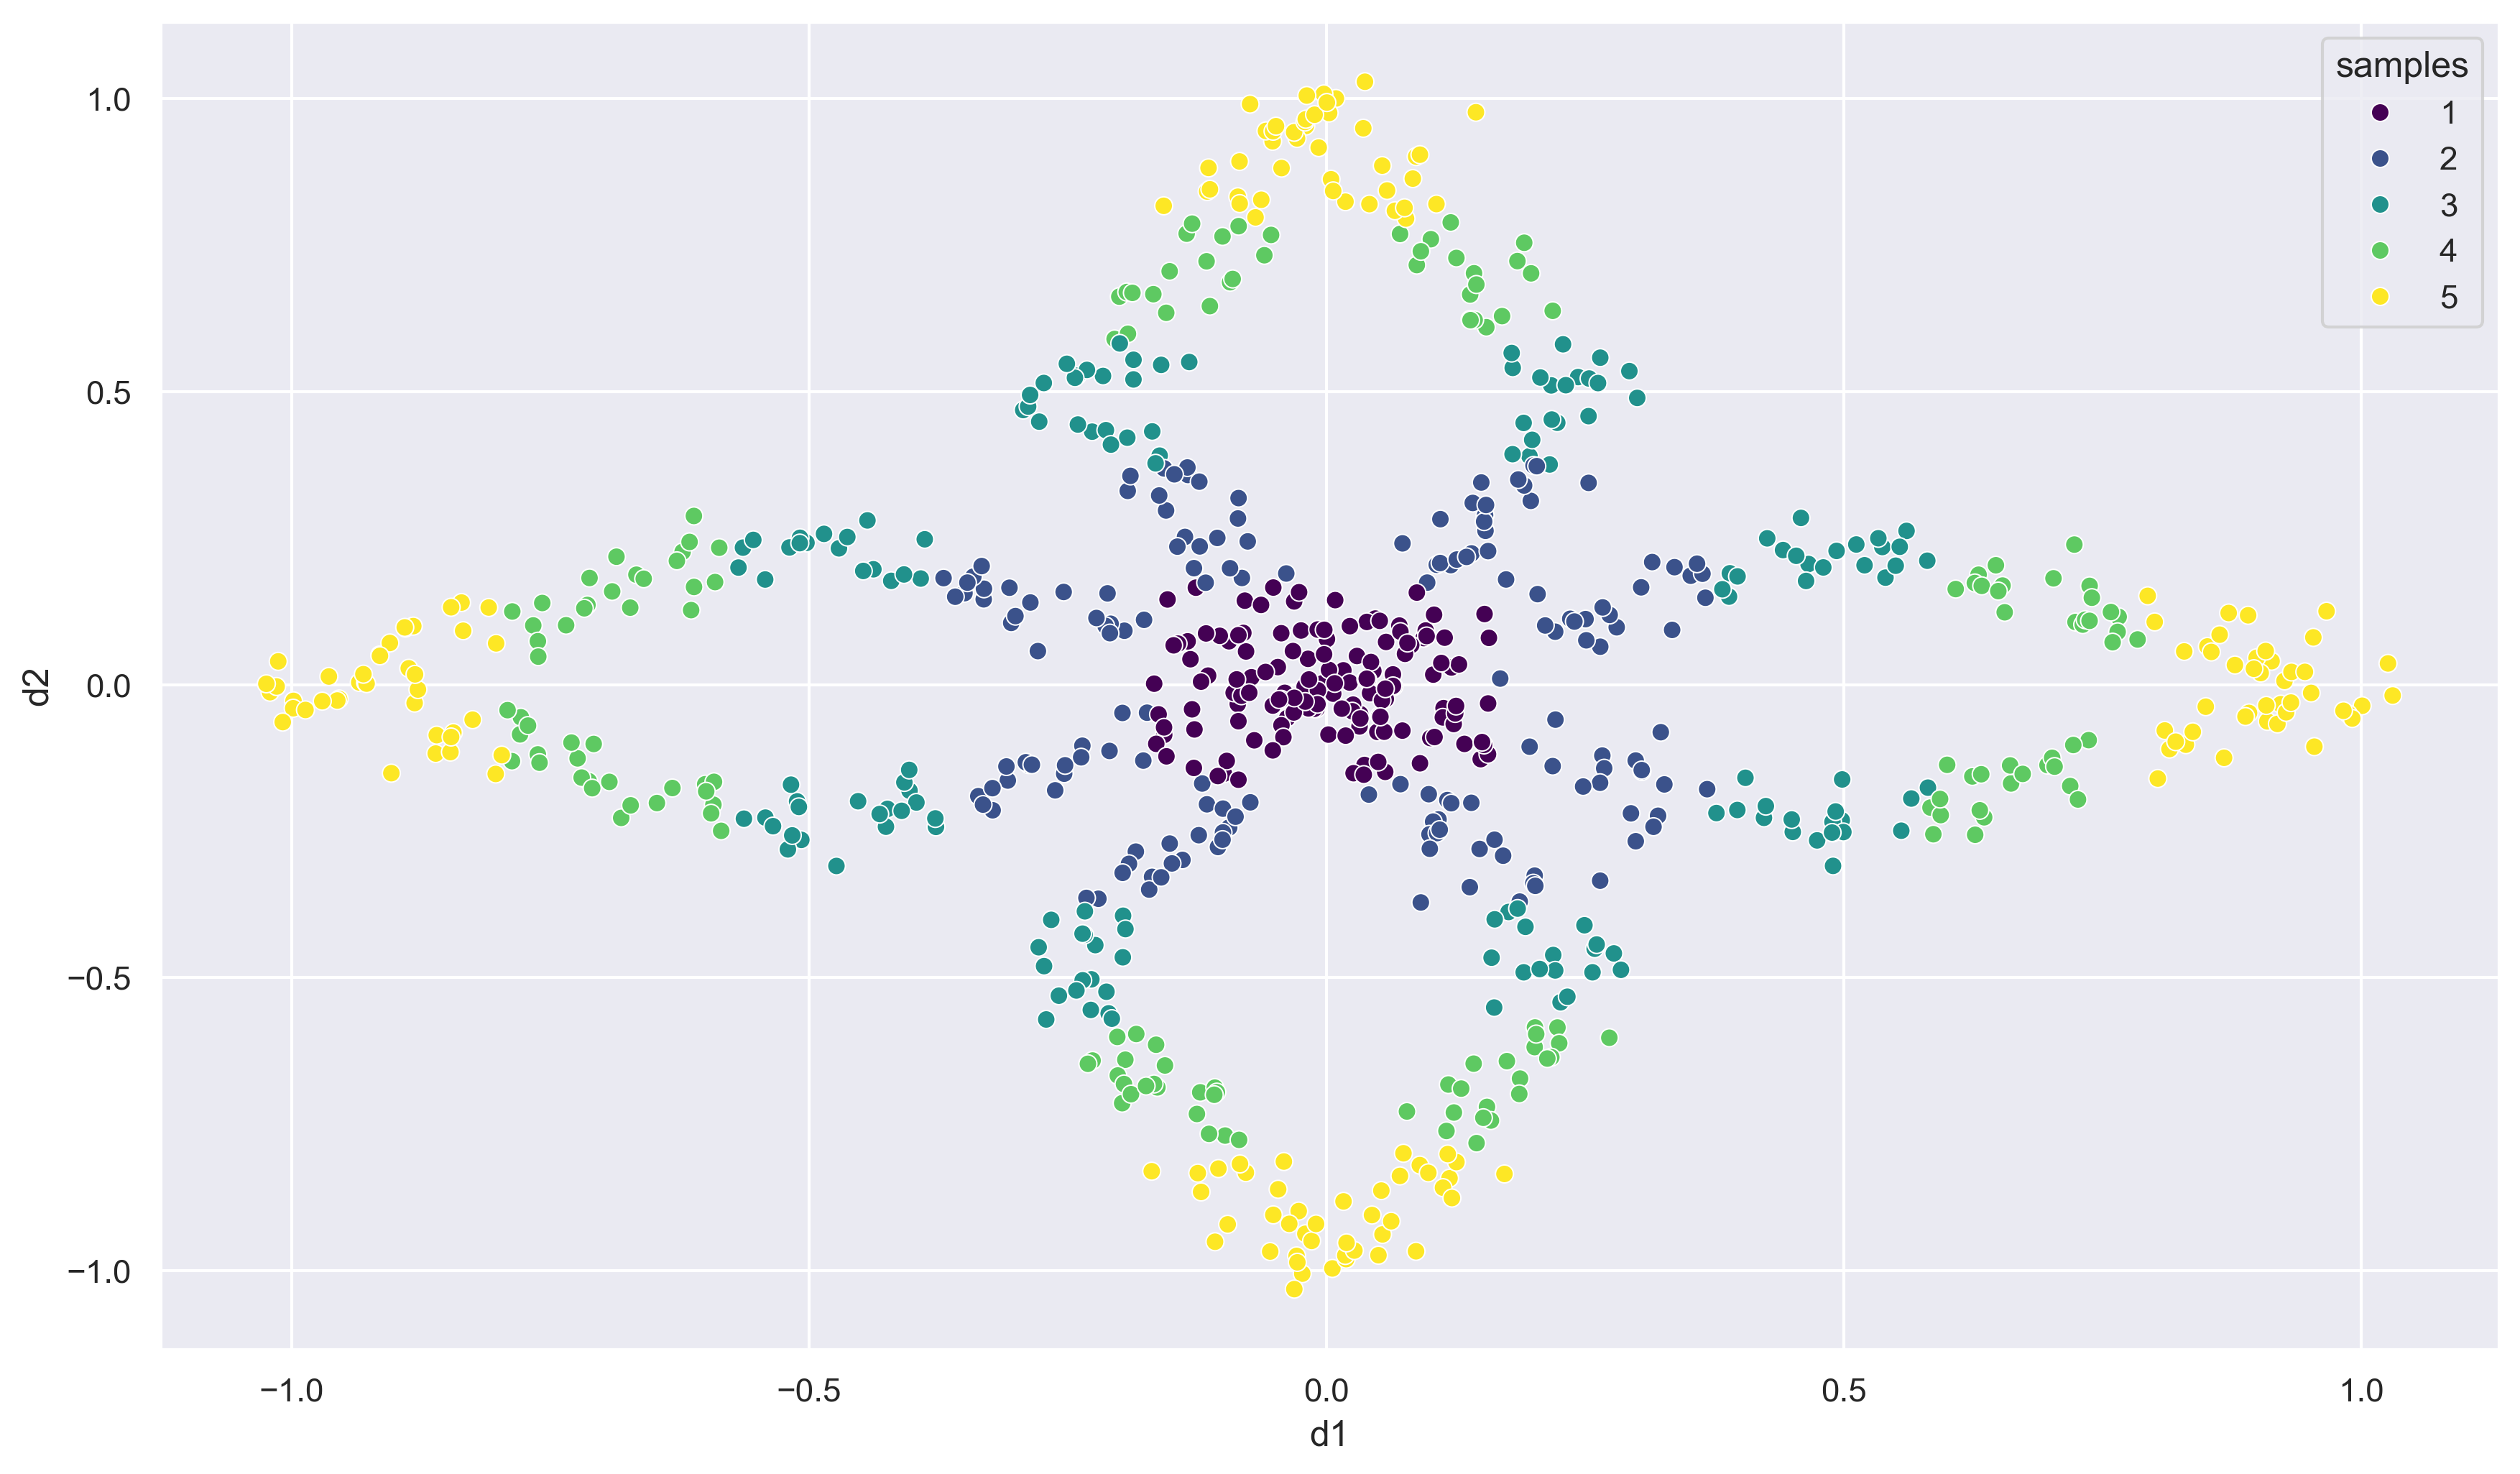

In [29]:
phate_dims = 5
df = make_diamonds()
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

### Train autoencoder or the geodesic embedding
Set seeds and check GPU

In [30]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

Handle hold-out training condition

In [31]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [32]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = True
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 32
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

Actually train the GAE

In [33]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss dist: 8.30949
Train loss dist: 5.73873
Train loss dist: 4.85869
Train loss dist: 4.17461
Train loss dist: 3.79892
Train loss dist: 3.60067
Train loss dist: 3.47256
Train loss dist: 3.45013
Train loss dist: 3.45767
Train loss dist: 3.19605
Train loss dist: 2.85484
Train loss dist: 2.63081
Train loss dist: 2.72672
Train loss dist: 2.73792
Train loss dist: 2.60057
Train loss dist: 2.56842
Train loss dist: 2.51728
Train loss dist: 2.27023
Train loss dist: 2.66613
Train loss dist: 2.62622
35.90794086456299


Specify Parameters

In [34]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 35

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda
)

In [35]:
# Basically "batch size"
sample_size=(60, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [36]:
opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [37]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir="../../results/", 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=None,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    use_penalty=True, lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time


Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 13.55665


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.45418


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.35885


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.88802


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.90261


  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 10.36713


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.61416


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.76695


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.46172


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.286


  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 6.4162


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.82284


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.29858


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.56144


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.29058


  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 8.54836


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.43002


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.44596


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.40091


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.42096


  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 6.70145


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.4297


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.61203


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.16615


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.80349


  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 8.31844


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.54874


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.93783


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.56048


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.79403


  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 6.42626


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.33885


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.25278


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.44193


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.38651


  0%|          | 0/20 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train loss: 7.08608


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.20789


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.14796


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.22183


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.97889


Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

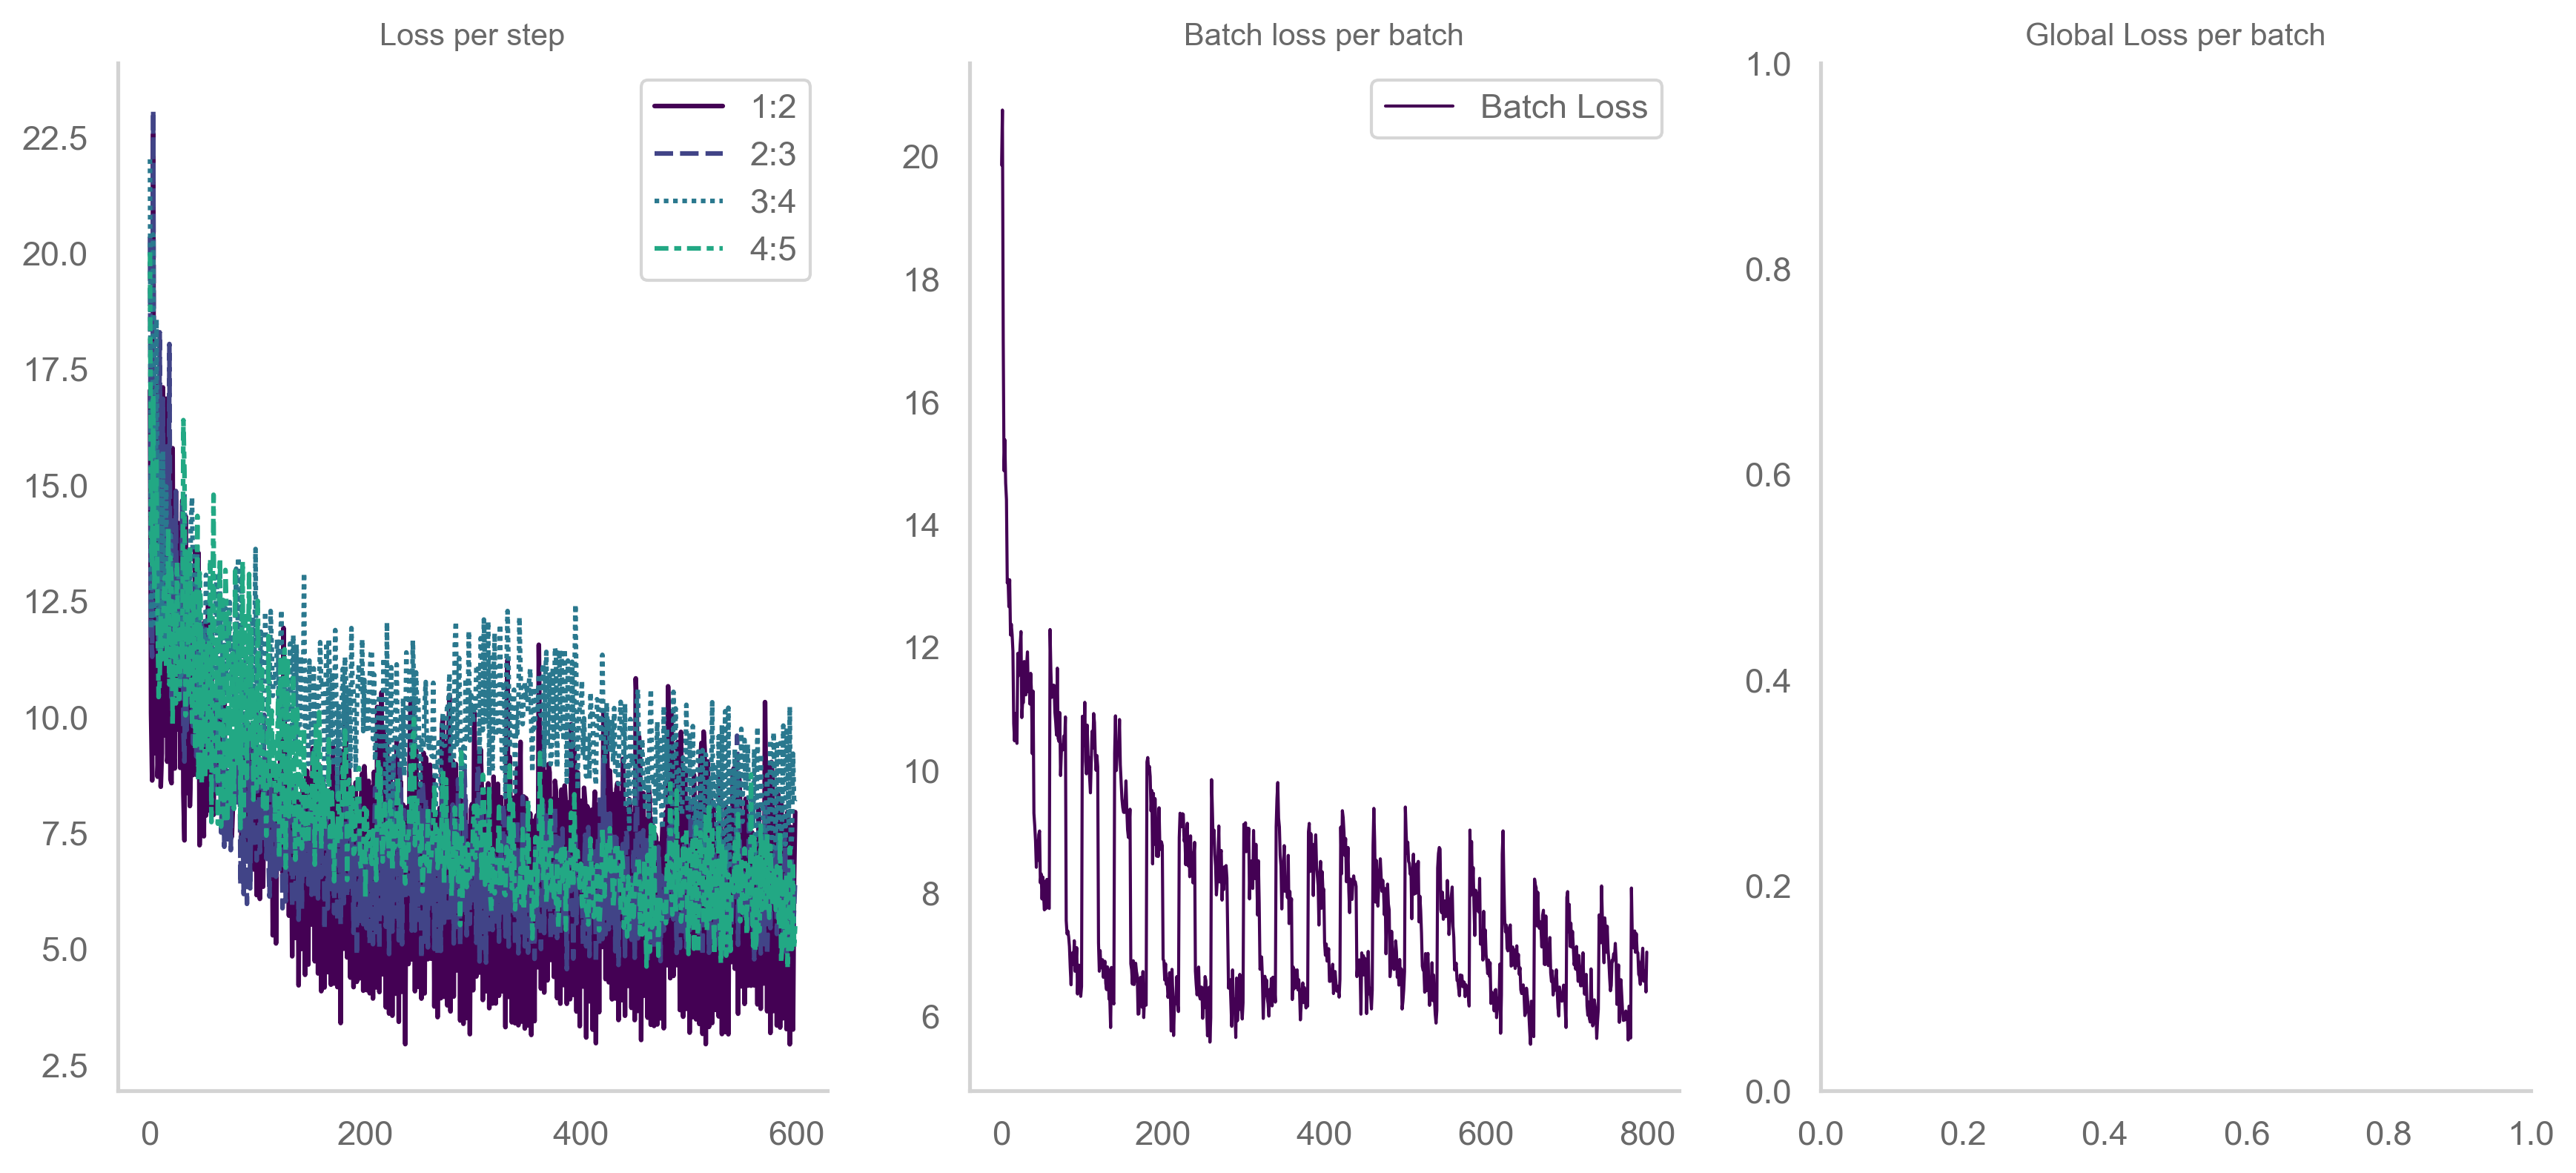

In [39]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=IMGS_DIR, file='losses.png'
)

In [41]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=None,
    autoencoder=autoencoder, recon=recon
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


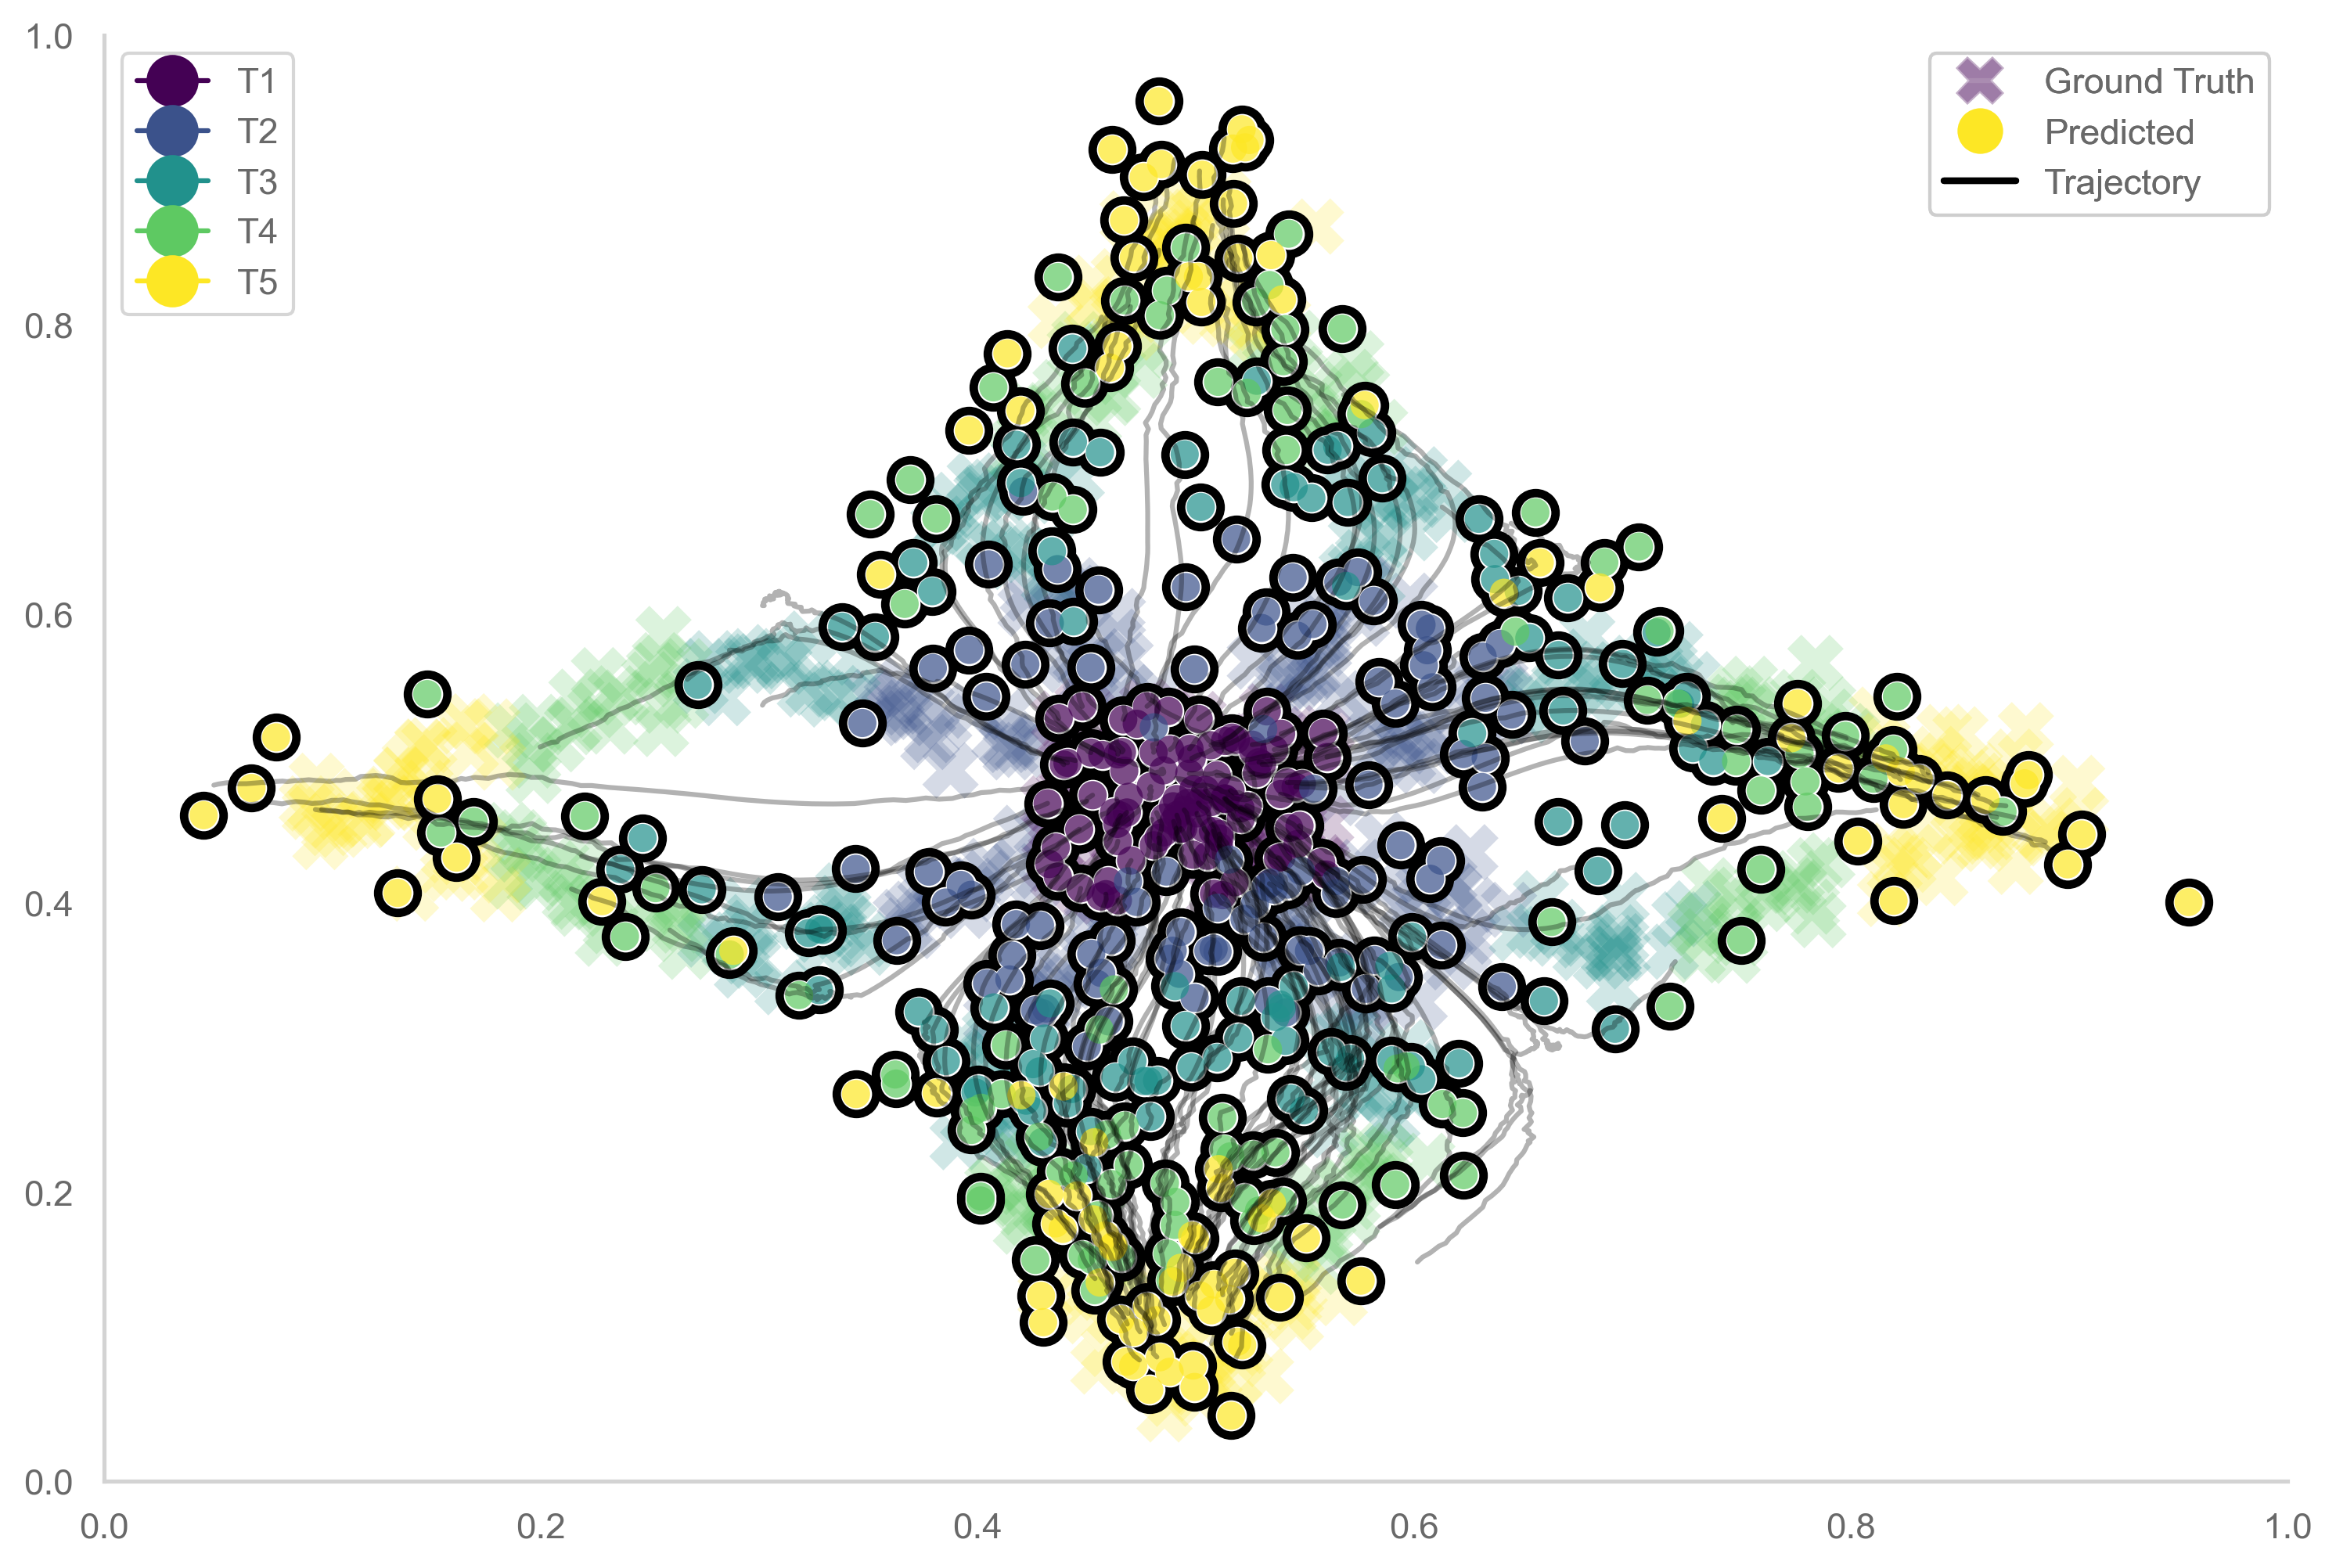

In [43]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=IMGS_DIR, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

# Modified Training for Neural Flattening

Here we make our mark on the previously untouched code, by modifying the guts of MIOFlow to make it a *neural flattener*. This means:

1. Instead of taking a list of pointclouds, including intermediate timescales, it only takes one pointcloud.
2. The $L_e$ loss will be replaced by the negative entropy of the local density.
3. Local and global training are now the same and will be combined.
4. (Optional) An additional loss will be added which preserves the radial distances between a center point and the rest of the dataset.

## A Uniform Density Loss

There are many possible ways to regularize the points to be uniformly distributed. The below has the advantages of being distance based, not kernel based. However, it remains to be seen whether gradients flow through this well. Minimizing the variance will penalize it to make the mean distances similar. Hopefully it sees that this can be easily achieved by flowing points out of dense regions into sparser ones.

In [28]:
#| export
class UniformDensityLoss(nn.Module):
    """
        Penalizes the input points X to be uniformly distributed in the space.
        The penalty is the variance of the mean distance between the top_k nearest neighbors of each point. 
        With uniform distribution, the mean distance should be the same for all points, and thus the variance should be 0.

    """
    def __init__(self):
        pass

    def __call__(self, X, top_k = 10):
        # print(source, target)
        c_dist = torch.cdist(X, X) 
        vals, inds = torch.topk(c_dist, 10, dim=1, largest=False, sorted=False)
        loss = torch.var(torch.mean(vals, dim=1))
        return loss

In [ ]:
#| export
import os, sys, json, math, itertools
import pandas as pd, numpy as np
import warnings

# from tqdm import tqdm
from tqdm.notebook import tqdm

import torch

# from MIOFlow.utils import sample, generate_steps
# from MIOFlow.losses import MMD_loss, OT_loss, Density_loss, Local_density_loss

def train_neural_flattener(
    model, df, groups, optimizer, n_batches=20, 
    criterion=MMD_loss(),
    use_cuda=False,

    sample_size=(100, ),
    sample_with_replacement=False,

    local_loss=True,
    global_loss=False,

    hold_one_out=False,
    hold_out='random',
    apply_losses_in_time=True,

    top_k = 5,
    hinge_value = 0.01,
    use_density_loss=True,
    # use_local_density=False,

    lambda_density = 1.0,

    autoencoder=None, 
    use_emb=True,
    use_gae=False,

    use_gaussian:bool=True, 
    add_noise:bool=False, 
    noise_scale:float=0.1,
    
    logger=None,

    use_penalty=False,
    lambda_energy=1.0,

    reverse:bool = False
):

    '''
    MIOFlow training loop
    
    Notes:
        - The argument `model` must have a method `forward` that accepts two arguments
            in its function signature:
                ```python
                model.forward(x, t)
                ```
            where, `x` is the input tensor and `t` is a `torch.Tensor` of time points (float).
        - The training loop is divided in two parts; local (predict t+1 from t), and global (predict the entire trajectory).
                        
    Arguments:
        model (nn.Module): the initialized pytorch ODE model.
        
        df (pd.DataFrame): the DataFrame from which to extract batch data.
        
        groups (list): the list of the numerical groups in the data, e.g. 
            `[1.0, 2.0, 3.0, 4.0, 5.0]`, if the data has five groups.
    
        optimizer (torch.optim): an optimizer initilized with the model's parameters.
        
        n_batches (int): Default to '20', the number of batches from which to randomly sample each consecutive pair
            of groups.
            
        criterion (Callable | nn.Loss): a loss function.
        
        use_cuda (bool): Defaults to `False`. Whether or not to send the model and data to cuda. 

        sample_size (tuple): Defaults to `(100, )`

        sample_with_replacement (bool): Defaults to `False`. Whether or not to sample data points with replacement.
        
        local_loss (bool): Defaults to `True`. Whether or not to use a local loss in the model.
            See notes for more detail.
            
        global_loss (bool): Defaults to `False`. Whether or not to use a global loss in the model.
        
        hold_one_out (bool): Defaults to `False`. Whether or not to randomly hold one time pair
            e.g. t_1 to t_2 out when computing the global loss.

        hold_out (str | int): Defaults to `"random"`. Which time point to hold out when calculating the
            global loss.
            
        apply_losses_in_time (bool): Defaults to `True`. Applies the losses and does back propegation
            as soon as a loss is calculated. See notes for more detail.

        top_k (int): Default to '5'. The k for the k-NN used in the density loss.

        hinge_value (float): Defaults to `0.01`. The hinge value for density loss.

        use_density_loss (bool): Defaults to `True`. Whether or not to add density regularization.

        lambda_density (float): Defaults to `1.0`. The weight for density loss.

        autoencoder (NoneType|nn.Module): Default to 'None'. The full geodesic Autoencoder.

        use_emb (bool): Defaults to `True`. Whether or not to use the embedding model.
        
        use_gae (bool): Defaults to `False`. Whether or not to use the full Geodesic AutoEncoder.

        use_gaussian (bool): Defaults to `True`. Whether to use random or gaussian noise.

        add_noise (bool): Defaults to `False`. Whether or not to add noise.

        noise_scale (float): Defaults to `0.30`. How much to scale the noise by.
        
        logger (NoneType|Logger): Default to 'None'. The logger to record information.

        use_penalty (bool): Defaults to `False`. Whether or not to use $L_e$ during training (norm of the derivative).
        
        lambda_energy (float): Default to '1.0'. The weight of the energy penalty.

        reverse (bool): Whether to train time backwards.
    '''
    if autoencoder is None and (use_emb or use_gae):
        use_emb = False
        use_gae = False
        warnings.warn('\'autoencoder\' is \'None\', but \'use_emb\' or \'use_gae\' is True, both will be set to False.')

    noise_fn = torch.randn if use_gaussian else torch.rand
    def noise(data):
        return noise_fn(*data.shape).cuda() if use_cuda else noise_fn(*data.shape)
    # Create the indicies for the steps that should be used
    steps = generate_steps(groups)

    if reverse:
        groups = groups[::-1]
        steps = generate_steps(groups)

    
    # Storage variables for losses
    batch_losses = []
    globe_losses = []
    if hold_one_out and hold_out in groups:
        groups_ho = [g for g in groups if g != hold_out]
        local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups_ho) if hold_out not in [t0, t1]}
    else:
        local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
        
    density_fn = Density_loss(hinge_value) # if not use_local_density else Local_density_loss()
    uniform_density_loss = UniformDensityLoss()

    # Send model to cuda and specify it as training mode
    if use_cuda:
        model = model.cuda()
    
    model.train()
    
    for batch in tqdm(range(n_batches)):
    
        optimizer.zero_grad()
        #sampling, predicting, and evaluating the loss.

        # data_ti is a list of sampled tensors from each provided timestep.
        # In our case, there is only one timestep, so it is a list of one tensor.
        # sample data from input pointcloud; looks like
        # [timestep1, timestep2, timestep3, ...]
        data_ti = [
            sample(
                df, group, size=sample_size, replace=sample_with_replacement, 
                to_torch=True, use_cuda=use_cuda
            )
            for group in groups
        ]
        # 0 is the input data, 1 is our desired transformation
        time = torch.Tensor([0,1]).cuda() if use_cuda else torch.Tensor([0,1])


        #  Add noise to data_ti and project it into the latent space.
        if add_noise:
            data_ti = [
                data + noise(data) * noise_scale for data in data_ti
            ]
        if autoencoder is not None and use_gae:
            data_ti = [autoencoder.encoder(data) for data in data_ti]

        
        # prediction: run the first samples through the neural ODE. I believe it returns a list of tensors, one for each time.
        # In our case, the only timestep is the first one, so it is a list of one tensor.f 
        data_tp = model(data_ti[0], time, return_whole_sequence=True)
        if autoencoder is not None and use_emb:  # ???? What's use_emb?
            data_tp = [autoencoder.encoder(data) for data in data_tp]
            data_ti = [autoencoder.encoder(data) for data in data_ti]

        #ignoring one time point
        to_ignore = None #TODO: This assignment of `to_ingnore`, could be moved at the beginning of the function. 
        if hold_one_out and hold_out == 'random':
            to_ignore = np.random.choice(groups)
        elif hold_one_out and hold_out in groups:
            to_ignore = hold_out
        elif hold_one_out:
            raise ValueError('Unknown group to hold out')
        else:
            pass

        # This is L_e; we replace this with the uniform density loss
        loss = uniform_density_loss(data_tp[-1]) 
        # loss = sum([
        #     criterion(data_tp[i], data_ti[i]) # criterion is an input parameter
        #     for i in range(1, len(groups))
        #     if groups[i] != to_ignore # nice double nested list comprehension
        # ])

        # This second density loss 
        if use_density_loss:                
            density_loss = density_fn(data_tp, data_ti, groups, to_ignore, top_k)
            density_loss = density_loss.to(loss.device)
            loss += lambda_density * density_loss

        if use_penalty:
            penalty = sum([model.norm[-(i+1)] for i in range(1, len(groups))
                if groups[i] != to_ignore])
            loss += lambda_energy * penalty
                                    
        loss.backward()
        optimizer.step()
        model.norm=[]

        globe_losses.append(loss.item())
        
    print_loss = globe_losses
    if logger is None:      
        tqdm.write(f'Train loss: {np.round(np.mean(print_loss), 5)}')
    else:
        logger.info(f'Train loss: {np.round(np.mean(print_loss), 5)}')
    return local_losses, batch_losses, globe_losses

In [44]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

<IPython.core.display.Javascript object>

 WARN pixi::project: ALPHA feature enabled!

It looks like your project contains `[pypi-dependencies]`. This feature is currently still in an ALPHA state!

You may encounter bugs or weird behavior. Please report any and all issues you encounter on our github repository:

	https://github.com/prefix-dev/pixi.

✨ Pixi task: nbdev_export                                  
